<a href="https://colab.research.google.com/github/harshaharod21/Clustering-Algorithm/blob/main/Clustering_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Question 1**: Analysing yellow taxi trip dataset to find clusters of location using DBSCAN algorithm

In [ ]:
#Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import plotly.express as px
from sklearn.decomposition import PCA
!pip install -U kaleido
import kaleido
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoSeries


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoSeries

### Loading the file

In [ ]:
import pyarrow.parquet as pq

trips = pq.read_table('/content/yellow_tripdata_2023-01 (1).parquet')
trips = trips.to_pandas()

In [ ]:
trips.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:32:10   2023-01-01 00:40:36             1.00   
1         2  2023-01-01 00:55:08   2023-01-01 01:01:27             1.00   
2         2  2023-01-01 00:25:04   2023-01-01 00:37:49             1.00   
3         1  2023-01-01 00:03:48   2023-01-01 00:13:25             0.00   
4         2  2023-01-01 00:10:29   2023-01-01 00:21:19             1.00   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.97        1.00                  N           161           141   
1           1.10        1.00                  N            43           237   
2           2.51        1.00                  N            48           238   
3           1.90        1.00                  N           138             7   
4           1.43        1.00                  N           107            79   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             2         9.30   1.00     0.50        0.00          0.00   
1             1         7.90   1.00     0.50        4.00          0.00   
2             1        14.90   1.00     0.50       15.00          0.00   
3             1        12.10   7.25     0.50        0.00          0.00   
4             1        11.40   1.00     0.50        3.28          0.00   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  
0                   1.00         14.30                  2.50         0.00  
1                   1.00         16.90                  2.50         0.00  
2                   1.00         34.90                  2.50         0.00  
3                   1.00         20.85                  0.00         1.25  
4                   1.00         19.68                  2.50         0.00

#### Checking for NaN values

In [ ]:
nan_counts = {}
for feature in trips.columns:
    nan_counts[feature] = trips[feature].isna().sum()

print("NaN counts for each feature:")
print(nan_counts)


NaN counts for each feature:
{'VendorID': 0, 'tpep_pickup_datetime': 0, 'tpep_dropoff_datetime': 0, 'passenger_count': 71743, 'trip_distance': 0, 'RatecodeID': 71743, 'store_and_fwd_flag': 71743, 'PULocationID': 0, 'DOLocationID': 0, 'payment_type': 0, 'fare_amount': 0, 'extra': 0, 'mta_tax': 0, 'tip_amount': 0, 'tolls_amount': 0, 'improvement_surcharge': 0, 'total_amount': 0, 'congestion_surcharge': 71743, 'airport_fee': 71743}


* We have 71,743 (approx. 2%) nan values for passenger_count and some other data feature.We will handle the nan value after performing EDA

#### Data Describe

In [ ]:
trips.describe()

VendorID  passenger_count  trip_distance  RatecodeID  PULocationID  \
count 3066766.00       2995023.00     3066766.00  2995023.00    3066766.00   
mean        1.73             1.36           3.85        1.50        166.40   
std         0.44             0.90         249.58        6.47         64.24   
min         1.00             0.00           0.00        1.00          1.00   
25%         1.00             1.00           1.06        1.00        132.00   
50%         2.00             1.00           1.80        1.00        162.00   
75%         2.00             1.00           3.33        1.00        234.00   
max         2.00             9.00      258928.15       99.00        265.00   

       DOLocationID  payment_type  fare_amount      extra    mta_tax  \
count    3066766.00    3066766.00   3066766.00 3066766.00 3066766.00   
mean         164.39          1.19        18.37       1.54       0.49   
std           69.94          0.53        17.81       1.79       0.10   
min            1.00          0.00      -900.00      -7.50      -0.50   
25%          114.00          1.00         8.60       0.00       0.50   
50%          162.00          1.00        12.80       1.00       0.50   
75%          234.00          1.00        20.50       2.50       0.50   
max          265.00          4.00      1160.10      12.50      53.16   

       tip_amount  tolls_amount  improvement_surcharge  total_amount  \
count  3066766.00    3066766.00             3066766.00    3066766.00   
mean         3.37          0.52                   0.98         27.02   
std          3.83          2.02                   0.18         22.16   
min        -96.22        -65.00                  -1.00       -751.00   
25%          1.00          0.00                   1.00         15.40   
50%          2.72          0.00                   1.00         20.16   
75%          4.20          0.00                   1.00         28.70   
max        380.80        196.99                   1.00       1169.40   

       congestion_surcharge  airport_fee  
count            2995023.00   2995023.00  
mean                   2.27         0.11  
std                    0.77         0.36  
min                   -2.50        -1.25  
25%                    2.50         0.00  
50%                    2.50         0.00  
75%                    2.50         0.00  
max                    2.50         1.25

* Data id from 2008(dec) to 2023(feb),but most of the values are from 2023 Jan,we see that 50% of the data is from 17th Jan and max for 2nd of Jan.
First lets analyse the data monthly(Jan 2023),the most recent one
* There are some extreme values which needs to be droped because the value seems unreasonable or might have been a misentered value(trip_distance,fare_amount,etc)

### 2 Days period dataset

In [ ]:
trips['tpep_pickup_datetime'] = pd.to_datetime(trips['tpep_pickup_datetime'])
trips['tpep_dropoff_datetime'] = pd.to_datetime(trips['tpep_dropoff_datetime'])

In [ ]:
trip_jan=trips.copy()

start_date = '2023-01-16'  # Example: January 1, 2023
end_date = '2023-01-18'    # Example: January 31, 2023

# Filter the DataFrame for the one-month period
trip_jan = trip_jan[(trip_jan['tpep_pickup_datetime'] >= start_date) & (trip_jan['tpep_pickup_datetime'] <= end_date)]
trip_jan = trip_jan[(trip_jan['tpep_dropoff_datetime'] >= start_date) & (trip_jan['tpep_dropoff_datetime'] <= end_date)]


* Total number of observation: **1,80,677**





In [ ]:
trip_jan.describe()

VendorID  passenger_count  trip_distance  RatecodeID  PULocationID  \
count 180677.00        176761.00      180677.00   176761.00     180677.00   
mean       1.73             1.33           3.72        1.50        167.23   
std        0.45             0.87          22.32        6.40         62.93   
min        1.00             0.00           0.00        1.00          1.00   
25%        1.00             1.00           1.09        1.00        132.00   
50%        2.00             1.00           1.80        1.00        162.00   
75%        2.00             1.00           3.50        1.00        234.00   
max        2.00             8.00        7907.26       99.00        265.00   

       DOLocationID  payment_type  fare_amount     extra   mta_tax  \
count     180677.00     180677.00    180677.00 180677.00 180677.00   
mean         165.53          1.19        19.20      1.51      0.49   
std           69.39          0.53        19.18      1.86      0.10   
min            1.00          0.00      -600.00     -7.50     -0.50   
25%          123.00          1.00         8.60      0.00      0.50   
50%          162.00          1.00        12.80      1.00      0.50   
75%          234.00          1.00        20.50      2.50      0.50   
max          265.00          4.00       600.00     11.25      0.80   

       tip_amount  tolls_amount  improvement_surcharge  total_amount  \
count   180677.00     180677.00              180677.00     180677.00   
mean         3.58          0.67                   0.98         28.17   
std          4.16          2.28                   0.19         24.25   
min        -20.00        -29.50                  -1.00       -603.50   
25%          1.00          0.00                   1.00         15.12   
50%          2.80          0.00                   1.00         19.90   
75%          4.20          0.00                   1.00         29.10   
max        222.21         81.55                   1.00        603.50   

       congestion_surcharge  airport_fee  
count             176761.00    176761.00  
mean                   2.24         0.14  
std                    0.81         0.40  
min                   -2.50        -1.25  
25%                    2.50         0.00  
50%                    2.50         0.00  
75%                    2.50         0.00  
max                    2.50         1.25

* Outliers are observed





In [ ]:
nan_counts = {}
for feature in trip_jan.columns:
    nan_counts[feature] = trip_jan[feature].isna().sum()

print("NaN counts for each feature:")
print(nan_counts)


NaN counts for each feature:
{'VendorID': 0, 'tpep_pickup_datetime': 0, 'tpep_dropoff_datetime': 0, 'passenger_count': 3916, 'trip_distance': 0, 'RatecodeID': 3916, 'store_and_fwd_flag': 3916, 'PULocationID': 0, 'DOLocationID': 0, 'payment_type': 0, 'fare_amount': 0, 'extra': 0, 'mta_tax': 0, 'tip_amount': 0, 'tolls_amount': 0, 'improvement_surcharge': 0, 'total_amount': 0, 'congestion_surcharge': 3916, 'airport_fee': 3916}


**3916** nan values

#### Handling Outliers

In [ ]:
#to handle outliers

Out_Feature=['trip_distance','fare_amount','tip_amount', 'tolls_amount','total_amount', 'congestion_surcharge', 'airport_fee']

for features in Out_Feature:

    Q1 = trip_jan[features].quantile(0.25)
    Q3 = trip_jan[features].quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    trip_jan = trip_jan[(trip_jan[features] >= lower_bound) & (trip_jan[features] <= upper_bound)]

In [ ]:
trip_jan.describe()

VendorID  passenger_count  trip_distance  RatecodeID  PULocationID  \
count 134345.00        134345.00      134345.00   134345.00     134345.00   
mean       1.72             1.33           1.73        1.00        173.19   
std        0.45             0.88           1.02        0.10         63.44   
min        1.00             0.00           0.00        1.00          4.00   
25%        1.00             1.00           1.00        1.00        140.00   
50%        2.00             1.00           1.50        1.00        164.00   
75%        2.00             1.00           2.25        1.00        236.00   
max        2.00             6.00           7.00        5.00        264.00   

       DOLocationID  payment_type  fare_amount     extra   mta_tax  \
count     134345.00     134345.00    134345.00 134345.00 134345.00   
mean         171.59          1.19        11.83      1.30      0.50   
std           66.64          0.44         4.81      1.43      0.01   
min            4.00          1.00         0.00      0.00      0.00   
25%          140.00          1.00         7.90      0.00      0.50   
50%          164.00          1.00        10.70      1.00      0.50   
75%          236.00          1.00        14.90      2.50      0.50   
max          264.00          4.00        27.50      5.00      0.80   

       tip_amount  tolls_amount  improvement_surcharge  total_amount  \
count   134345.00     134345.00              134345.00     134345.00   
mean         2.42          0.00                   1.00         18.85   
std          1.63          0.00                   0.03          5.70   
min          0.00          0.00                   0.30          3.50   
25%          1.00          0.00                   1.00         14.56   
50%          2.54          0.00                   1.00         18.00   
75%          3.50          0.00                   1.00         22.33   
max          7.45          0.00                   1.00         35.10   

       congestion_surcharge  airport_fee  
count             134345.00    134345.00  
mean                   2.50         0.00  
std                    0.00         0.00  
min                    2.50         0.00  
25%                    2.50         0.00  
50%                    2.50         0.00  
75%                    2.50         0.00  
max                    2.50         0.00

* Tolls amount have all values 0 after removing outliers so we drop it

In [ ]:
trip_jan.drop(columns='tolls_amount', inplace=True)

### Distribution of features

In [ ]:
trip_copy=trip_jan.copy()

In [ ]:
#columns not important to visulaize the distribution are removed

columns_to_remove = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime','store_and_fwd_flag']
#col=list(trip_copy.columns)
trip_copy.drop(columns=columns_to_remove, inplace=True)
col=list(trip_copy.columns)
feature=[*col]


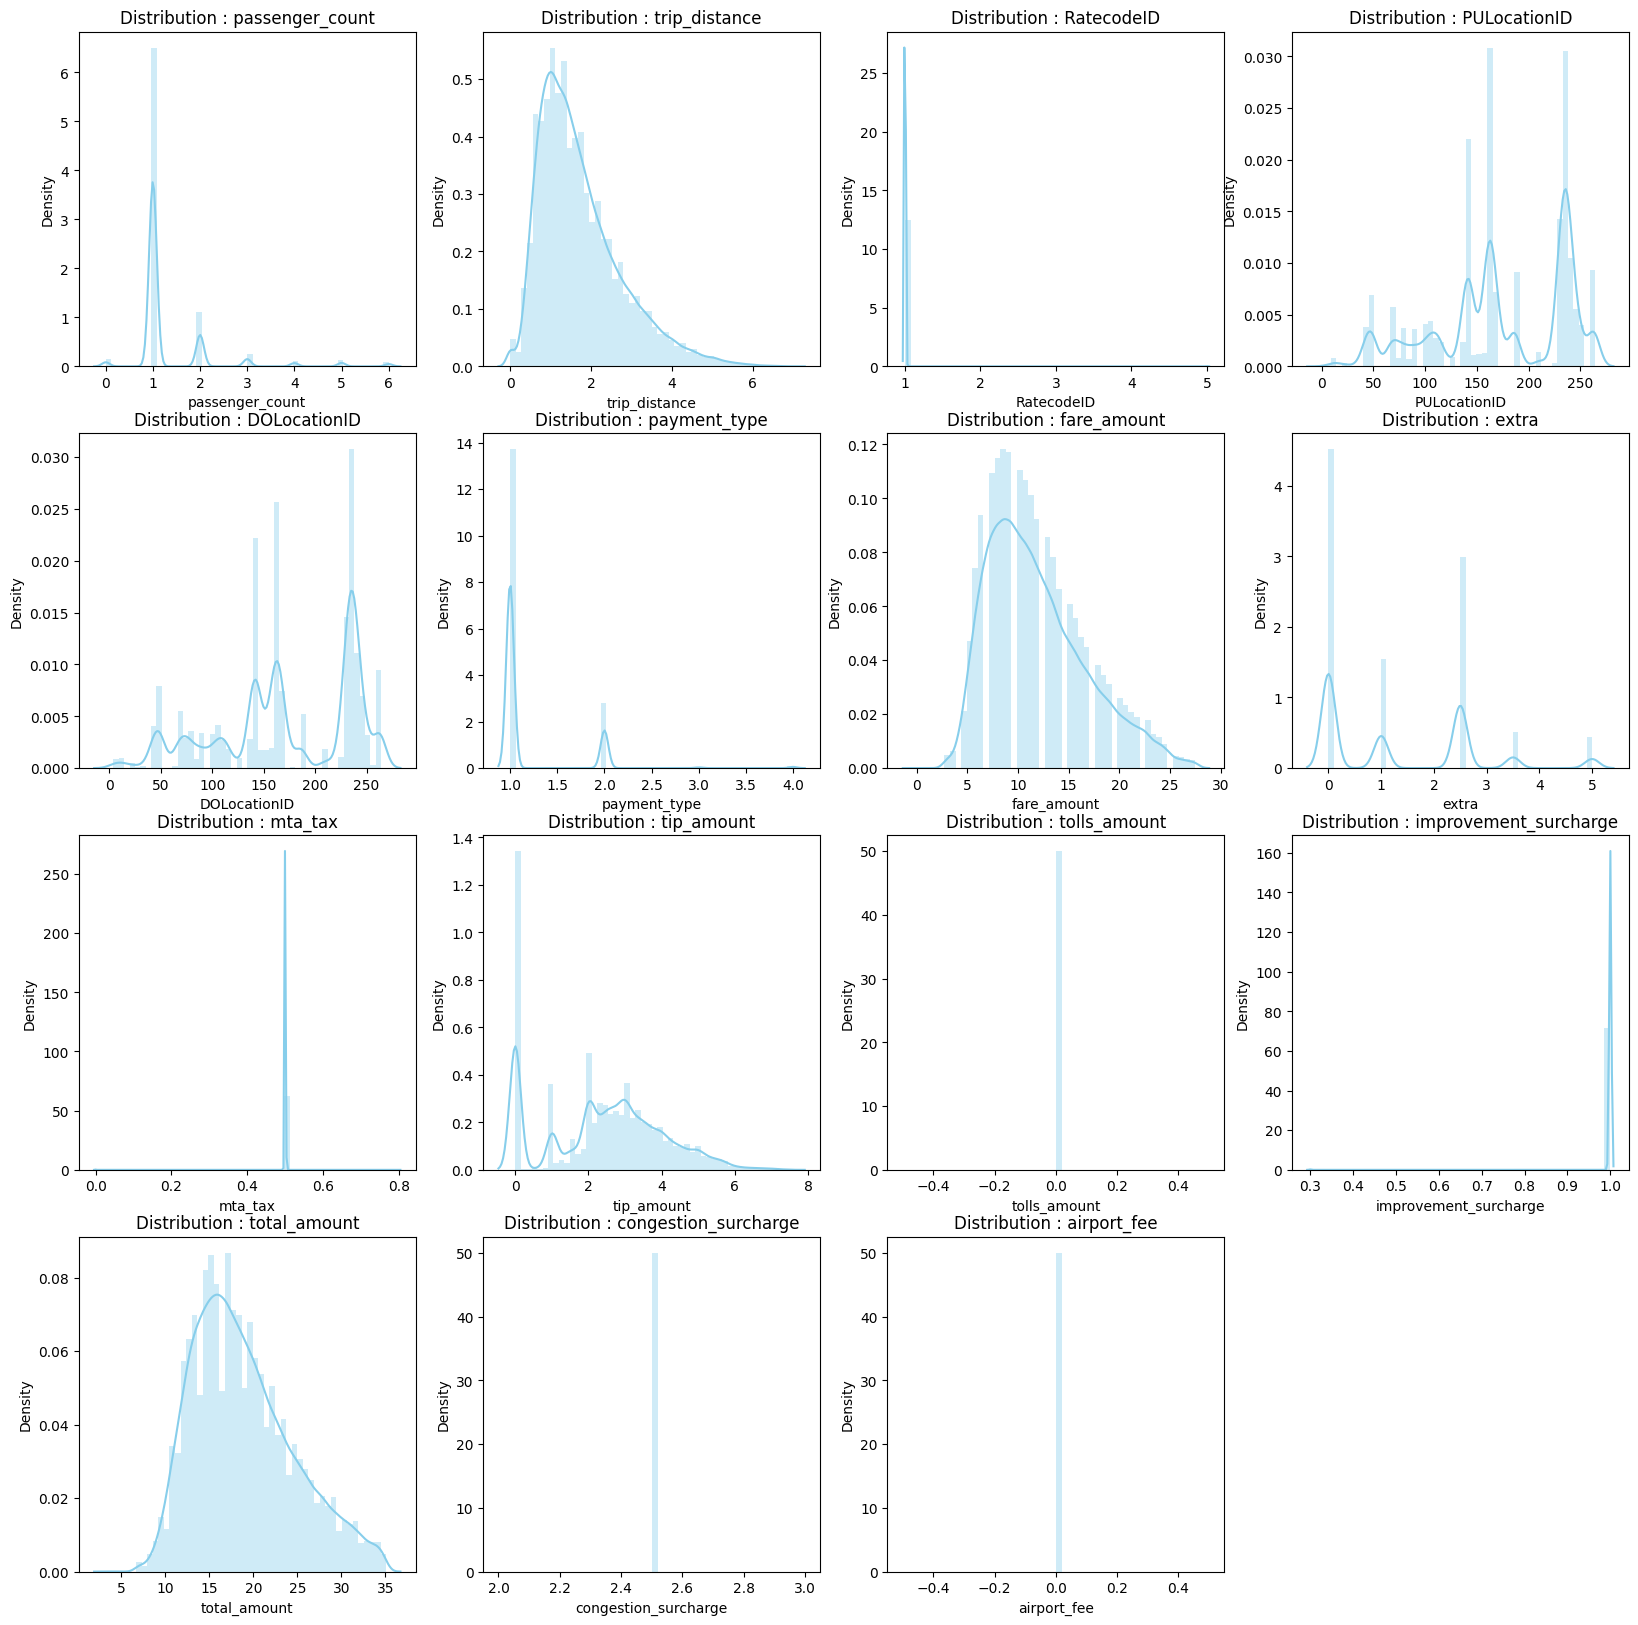

In [ ]:

colors = ['#87CEEB', '#FFA07A']
fig, ax = plt.subplots(nrows = 3,ncols = 5,figsize = (20,20))
for i in range(len(feature)):
    plt.subplot(4,4,i+1)
    sns.distplot(trip_copy[feature[i]],color = colors[0])
    title = 'Distribution : ' + feature[i]
    plt.title(title)
plt.show()

* The pickup and dropoff location id is very similar
* We can observe that most of the feature follow a skewed distribution or follow mixed distribution

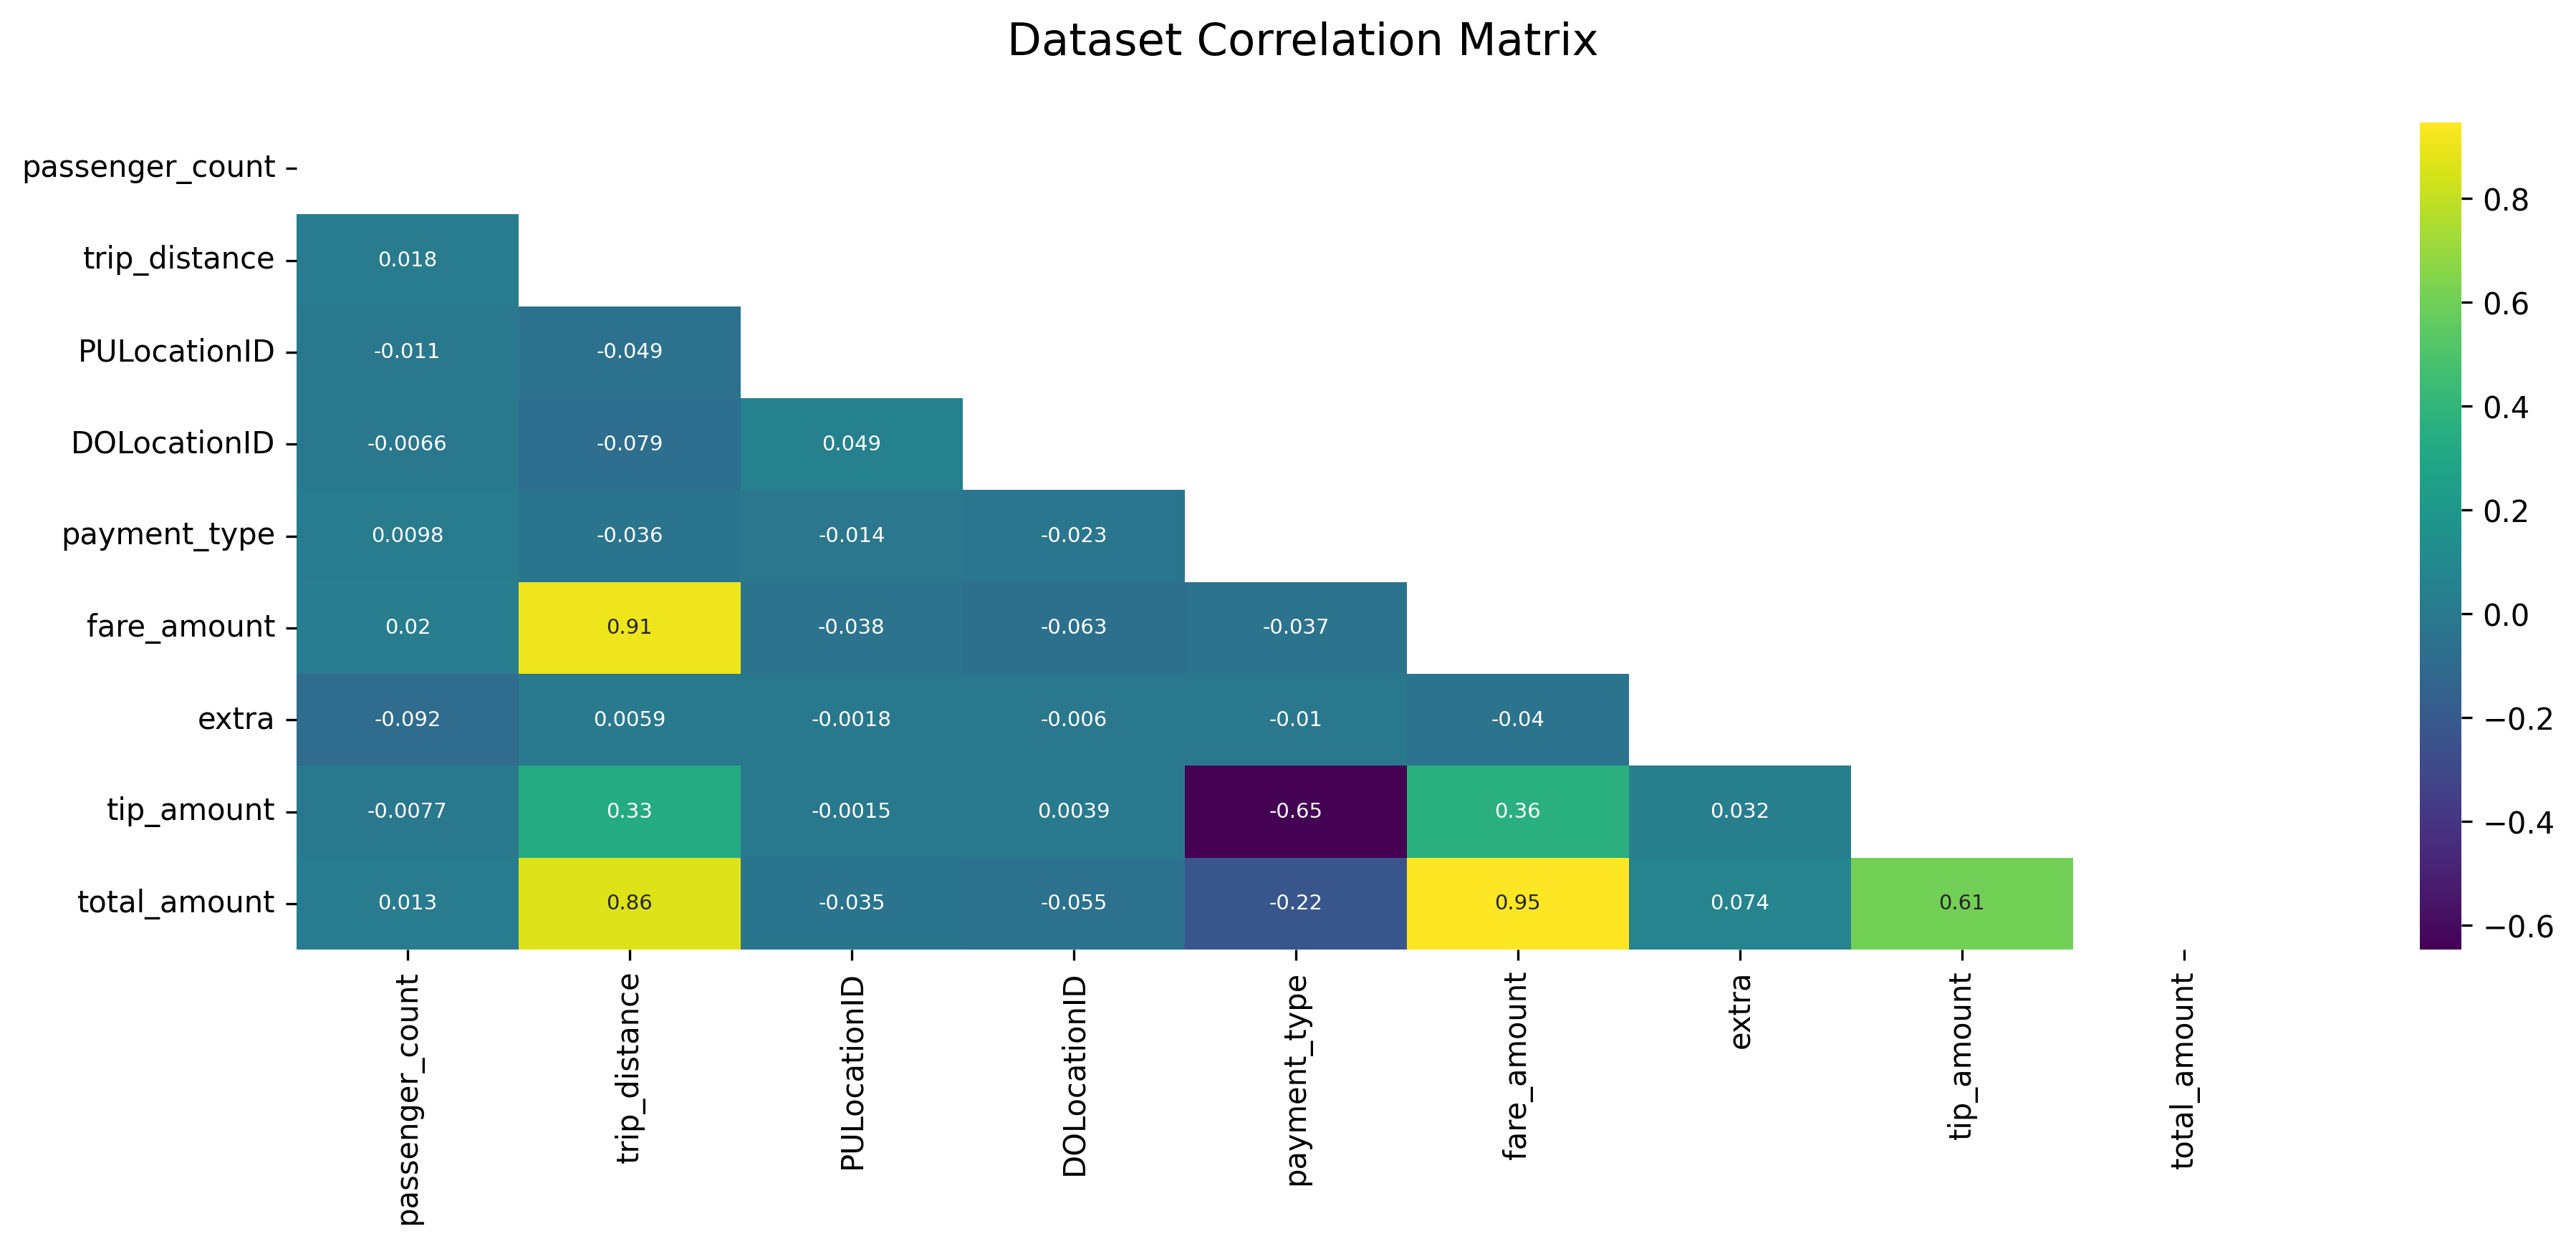

In [ ]:
corr = trip_copy.corr()
plt.figure(figsize = (15, 5), dpi = 300)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, cmap = 'viridis', annot = True, annot_kws = {'size' : 7})
plt.title(f' Dataset Correlation Matrix\n', fontsize = 15)
plt.show()

* The correlation is higher for total_amount and tip_amount with all other variable relatively compared to other variable
* All other variable show some correlation in the range -0.2 to 0.2

#### Dropping features

In [ ]:
#droping this value because it has a uniform distribution and hence constant value

drop_features=['RatecodeID','mta_tax', 'improvement_surcharge','congestion_surcharge', 'airport_fee']
trip_copy.drop(columns=drop_features, inplace=True)


#### Handling missing values

In [ ]:
trip_copy=trip_copy.dropna()

In [ ]:
trip_copy.columns

Index(['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'tip_amount', 'total_amount'],
      dtype='object')

### PCA

Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization


In [ ]:
#Using min-max scalar as most of the dataset is not normally distributed

df = trip_copy.copy()

col = list(trip_copy.columns)

for i in col:
    df[i] = mms.fit_transform(df[[i]]) # Normalization

df.head()

passenger_count  trip_distance  PULocationID  DOLocationID  \
1403376             0.17           0.28          0.53          0.87   
1403623             0.50           0.08          0.87          0.61   
1405052             0.17           0.05          0.17          0.17   
1406021             0.17           0.23          0.25          0.29   
1406541             0.17           0.35          0.87          0.89   

         payment_type  fare_amount  extra  tip_amount  total_amount  
1403376          0.33         0.49   0.20        0.00          0.47  
1403623          0.33         0.19   0.20        0.00          0.21  
1405052          0.33         0.39   0.20        0.00          0.39  
1406021          0.00         0.41   0.20        0.13          0.44  
1406541          0.33         0.52   0.20        0.00          0.50

Principal Component Analysis (PCA)

In [ ]:
pca = PCA()
pca_df = pd.DataFrame(pca.fit_transform(df))
pca.explained_variance_

array([0.10004232, 0.08224953, 0.06698438, 0.05829147, 0.04187223,
       0.02105587, 0.00864689, 0.00268737, 0.00027298])

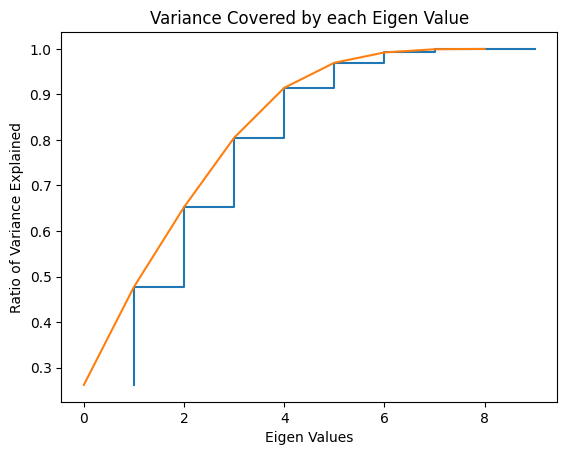

In [ ]:
plt.step(list(range(1,10)), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Eigen Values')
plt.ylabel('Ratio of Variance Explained')
plt.title('Variance Covered by each Eigen Value')
plt.show()



*   We observe that upto 4 eigen value we have 80% of total variation captured
*   So we drop the rest



In [ ]:
#columns to remove
pca_df = pca_df.drop(columns = [4,5,6,7,8])
pca_df.head()


0     1     2     3
0 -0.21 -0.04 -0.08  0.21
1 -0.57 -0.00  0.04 -0.20
2 -0.30 -0.03  0.69  0.27
3 -0.07 -0.05  0.50  0.24
4 -0.19 -0.05 -0.23 -0.09

[-0.00094527  0.36961511 -0.06289856 -0.1096955  -0.1877028   0.46743649
  0.13696432  0.52621025  0.5459018 ]
[-0.06361205 -0.06628011  0.01366436  0.01401609  0.01685405 -0.1115184
  0.98669261 -0.05024523 -0.04868244]


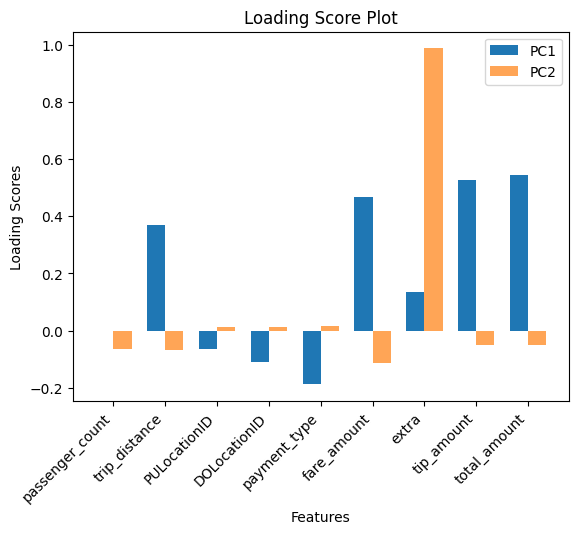

In [ ]:
# Create a DataFrame with loading scores for each feature

loading_scores = pca.components_

loading_scores_df = pd.DataFrame(loading_scores, columns=df.columns)
print(loading_scores[0])
print(loading_scores[1])

# Side-by-side bar plot of loading scores for PC1 and PC2
bar_width = 0.35
index = np.arange(len(df.columns))

plt.bar(index, loading_scores_df.iloc[0, :], width=bar_width, label='PC1')
plt.bar(index + bar_width, loading_scores_df.iloc[1, :], width=bar_width, label='PC2', alpha=0.7)

plt.xlabel('Features')
plt.ylabel('Loading Scores')
plt.title('Loading Score Plot')
plt.xticks(index + bar_width / 2,df.columns, rotation=45, ha='right')  # Rotate x-axis labels
plt.legend()
plt.show()



*   Observing the loading scores of the first two principal components we see that for PC1 features like trip_distance,fare_amount,tip_amount and total_amount ,these are positively correlated and captures the most variation and hence are important features.Similarly for PC2 its feature 'extra'.




In [ ]:
m2 = pca_df.values

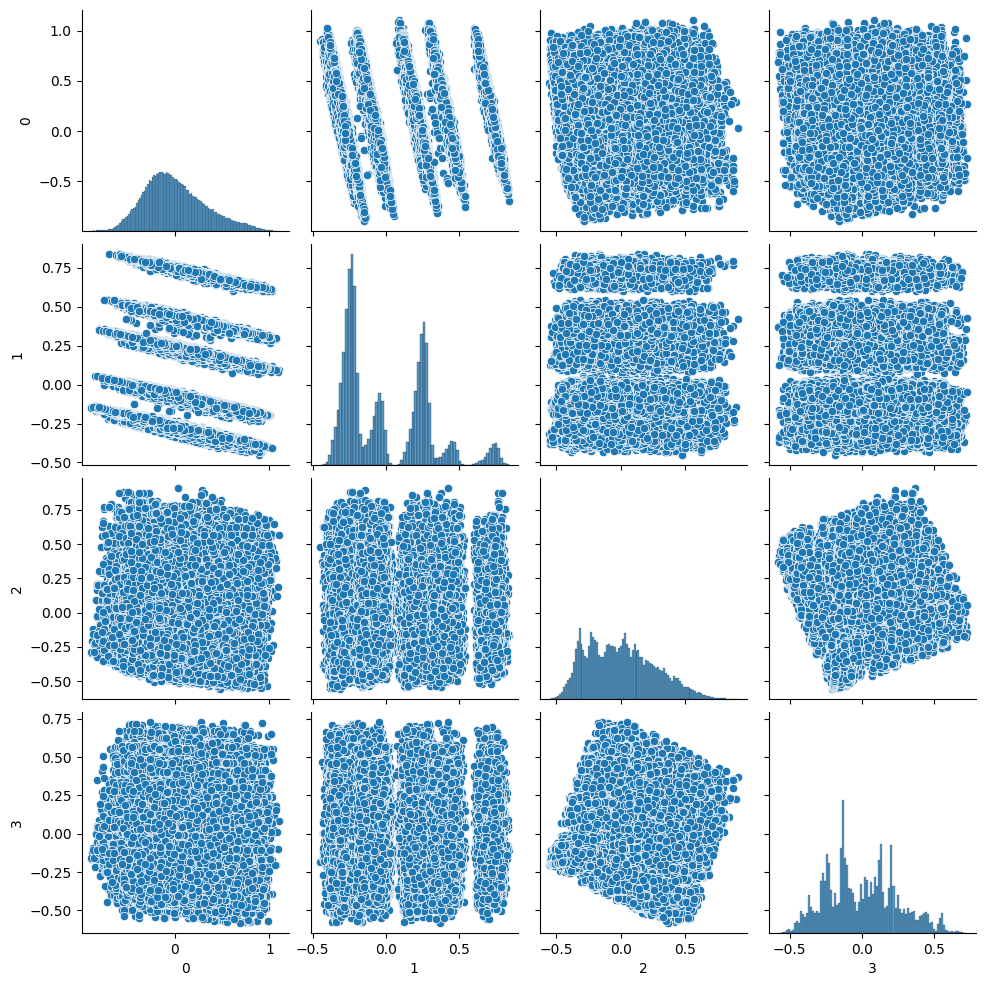

In [ ]:
sns.pairplot(pca_df)
plt.show()



*   As we can observe 0th and 1st pca components capturing the most variation compared to other pairs shows better clusttering




### DBSCAN Clustering

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

* To determine the optimal value of epsilon
* After many iteration of DBSCAN forthis dataset using different values of min-points we observed that the dataset is noisy and we already know that it is a large dataset.So we take a large value of min-point > 2D




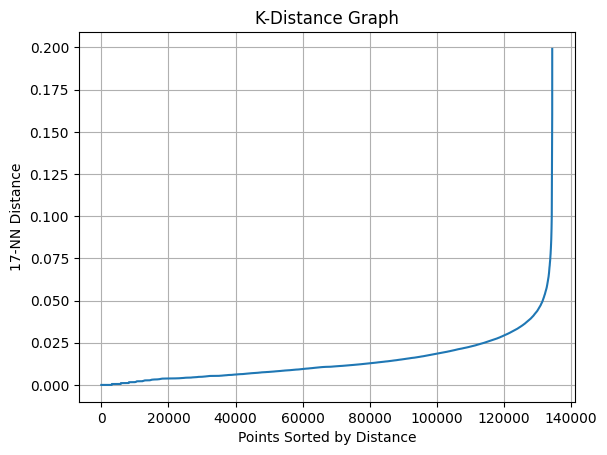

In [ ]:
knn = NearestNeighbors(n_neighbors = 17)
model = knn.fit(m2)
distances, indices = knn.kneighbors(m2)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.xlabel('Points Sorted by Distance')
plt.ylabel('17-NN Distance')
plt.title('K-Distance Graph');
plt.grid()
plt.plot(distances);

In [ ]:
pip install kneed

0.026734898974951214


<Figure size 500x500 with 0 Axes>

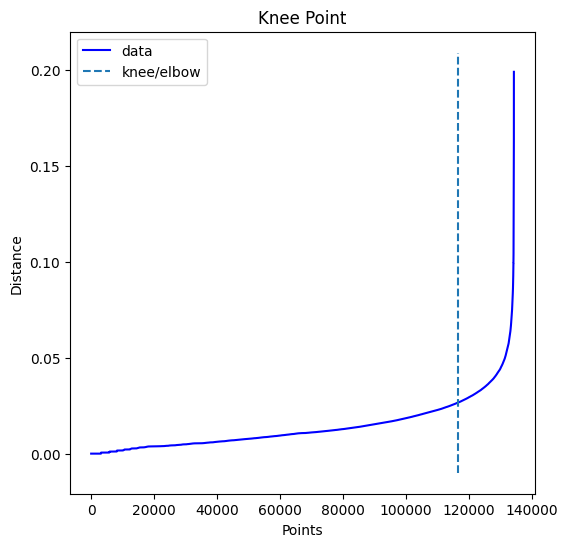

In [ ]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

Optimal epsilon value: **0.02**

I'm using the epislon value =0.2 as with 3D visualization I observed that 3 clusters are formed with this value,so ignoring the influence of 4th component which seem to create a lot of outliers with epsilon 0.02

In [ ]:
db = DBSCAN(eps = 0.2, min_samples = 100).fit(m2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Number of Clusters : ', n_clusters_)
print('Number of Outliers : ', n_noise_)

#data['Class'] = labels; pca_df2['Class'] = labels

Number of Clusters :  3
Number of Outliers :  477


* We will remove the outliers to visualize better

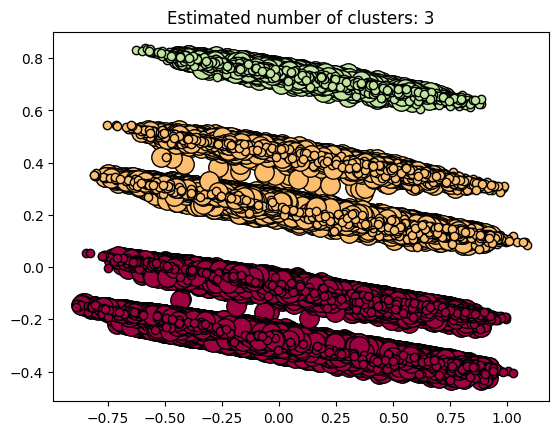

In [ ]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Skip plotting noise points
        continue

    class_member_mask = labels == k

    xy = m2[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col), markeredgecolor="k", markersize=14)

    xy = m2[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col), markeredgecolor="k", markersize=6)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

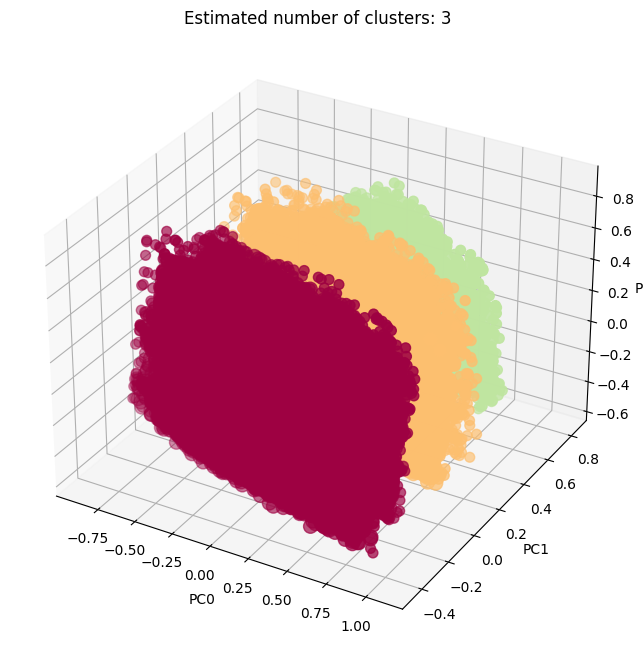

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Skip plotting noise points
        continue

    class_member_mask = labels == k

    xy = m2[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], marker='o', c=[col], s=100)

    xy = m2[class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], marker='o', c=[col], s=50)

ax.set_title("Estimated number of clusters: %d" % n_clusters_)
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
plt.show()

In [ ]:
trip_copy['Class']=labels

In [ ]:
cluster_labels, cluster_counts = np.unique(labels, return_counts=True)

# Print the number of data points in each cluster
for label, count in zip(cluster_labels, cluster_counts):
    if label == -1:
        print(f"Noise points: {count}")
    else:
        print(f"Cluster {label}: {count} data points")

Noise points: 477
Cluster 0: 81338 data points
Cluster 1: 46960 data points
Cluster 2: 5570 data points


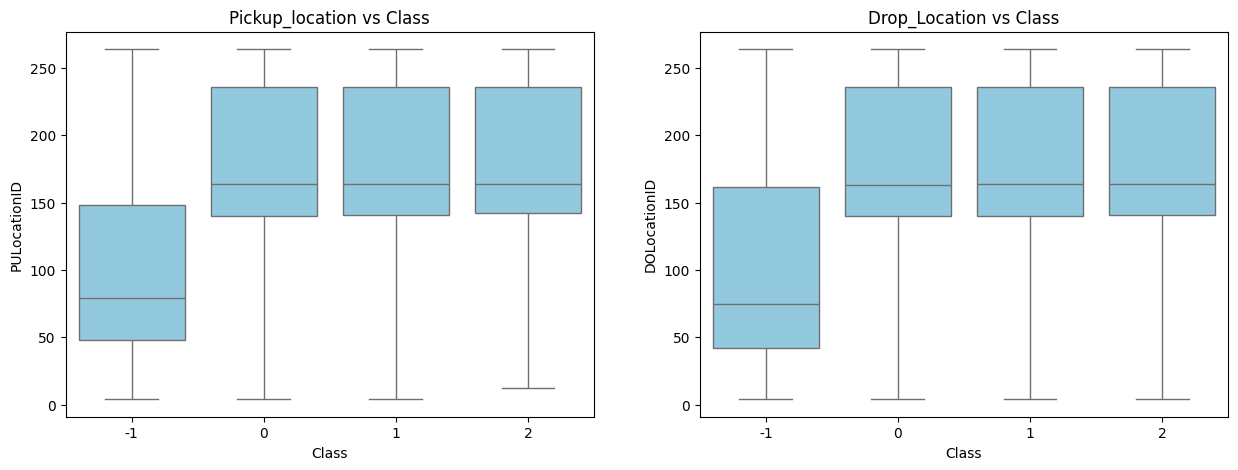

In [ ]:
#Boxplots to display the distribution of clusters across location

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'PULocationID', data  = trip_copy, color = '#87CEEB');
plt.title('Pickup_location vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'DOLocationID', data  = trip_copy, color = '#87CEEB');
plt.title('Drop_Location vs Class')

plt.show()

In [ ]:
passenger_count	trip_distance	PULocationID	DOLocationID	payment_type	fare_amount	extra	tip_amount	total_amount

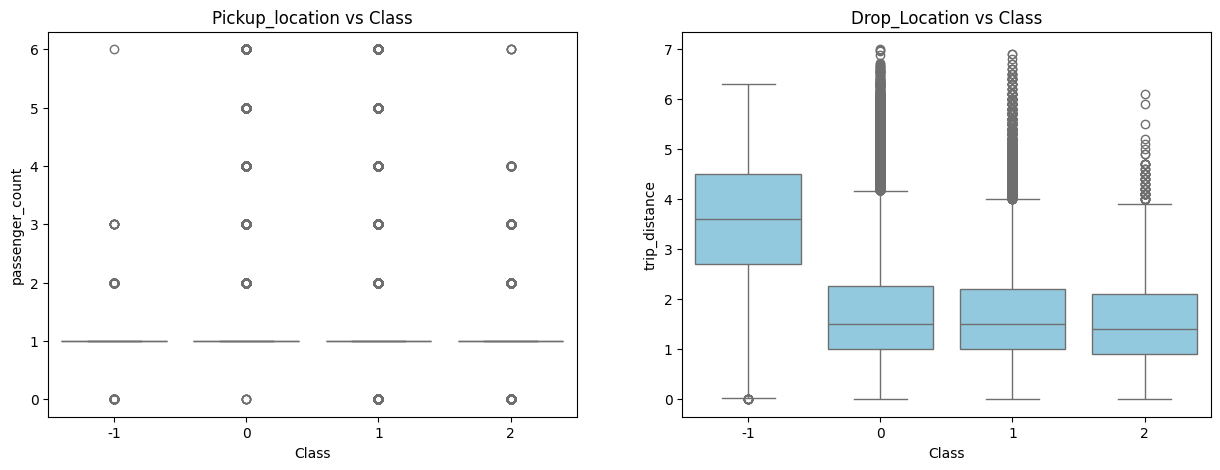

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'passenger_count', data  = trip_copy, color = '#87CEEB');
plt.title('Pickup_location vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'trip_distance', data  = trip_copy, color = '#87CEEB');
plt.title('Drop_Location vs Class')

plt.show()

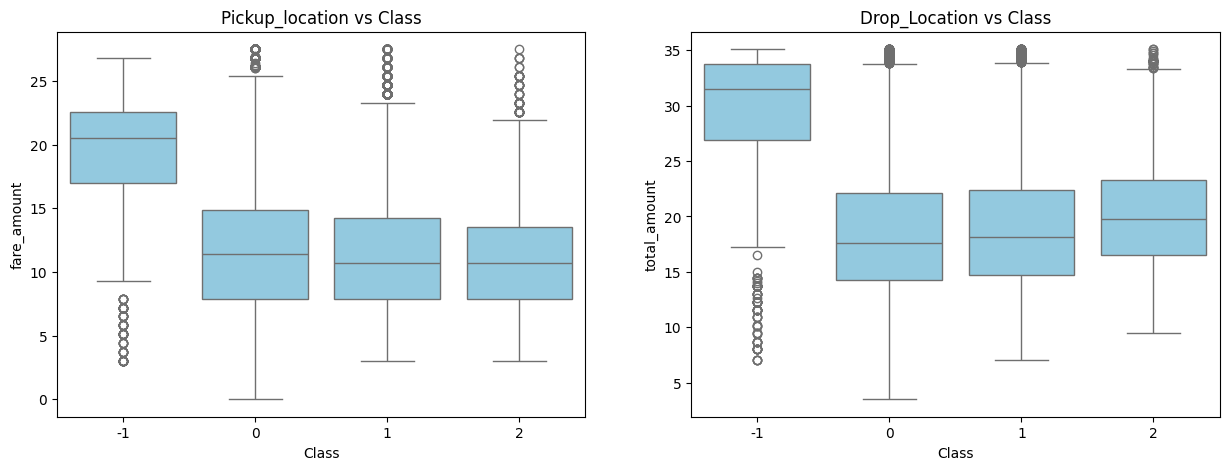

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'fare_amount', data  = trip_copy, color = '#87CEEB');
plt.title('Pickup_location vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'Class', y = 'total_amount', data  = trip_copy, color = '#87CEEB');
plt.title('Drop_Location vs Class')

plt.show()

In [ ]:
zone_df=pd.read_csv('/content/ZoneLookup.csv')

In [ ]:
zone_df.head()

ZoneId  Latitude  Longitude
0       1 191376.75  935996.82
1       2 164018.75 1031085.72
2       3 254265.48 1026452.62
3       4 202959.78  990633.98
4       5 140681.35  931871.37

In [ ]:
df_pickup=trip_copy[['PULocationID','Class']]
df_dropoff=trip_copy[['DOLocationID','Class']]

#merge with lookupdataset

df_pickup = pd.merge(df_pickup, zone_df, left_on='PULocationID', right_on='ZoneId', how='left')
df_pickup.rename(columns={'Latitude': 'pickup_latitude', 'Longitude': 'pickup_longitude'}, inplace=True)
df_pickup.drop('PULocationID', axis=1, inplace=True)

df_dropoff = pd.merge(df_dropoff, zone_df, left_on='DOLocationID', right_on='ZoneId', how='left')
df_dropoff.rename(columns={'Latitude': 'dropoff_latitude', 'Longitude': 'dropoff_longitude'}, inplace=True)
df_dropoff.drop('DOLocationID', axis=1, inplace=True)




In [ ]:
occurrences = df_dropoff['ZoneId'].value_counts()

# Count the occurrences of '264' and '265'
count_264 = occurrences.get(264, 0)
count_265 = occurrences.get(265, 0)

print("Occurrences of '264':", count_264)
print("Occurrences of '265':", count_265)

Occurrences of '264': 0
Occurrences of '265': 0


In [ ]:
df_pickup = df_pickup.dropna()

df_dropoff=df_dropoff.dropna()

In [ ]:
nan_counts = {}
for feature in df_pickup.columns:
    nan_counts[feature] = df_pickup[feature].isna().sum()

print("NaN counts for each feature:")
print(nan_counts)

NaN counts for each feature:
{'Class': 0, 'ZoneId': 0, 'pickup_latitude': 0, 'pickup_longitude': 0}


In [ ]:
pip install pyproj

In [ ]:
zone_xy=pd.read_csv('/content/ZoneLookup.csv')

In [ ]:
zone_xy.head()

ZoneId  Latitude  Longitude
0       1 191376.75  935996.82
1       2 164018.75 1031085.72
2       3 254265.48 1026452.62
3       4 202959.78  990633.98
4       5 140681.35  931871.37

In [ ]:
import pyproj

def convert_projected_to_latlon(x, y, source_epsg, dest_epsg=4326):
    source_proj = pyproj.Proj(f'epsg:{source_epsg}')
    dest_proj = pyproj.Proj(f'epsg:{dest_epsg}')
    lon, lat = pyproj.transform(source_proj, dest_proj, x, y)
    return lat, lon

# Read the file containing zone IDs and x-y coordinates into a DataFrame
# Replace 'filename.csv' with the actual path to your file
zone_xy = pd.read_csv('/content/ZoneLookup.csv')

# Create lists to store latitudes and longitudes
latitudes = []
longitudes = []
# Iterate over each row in the DataFrame
for index, row in zone_xy.iterrows():

    x = row['Longitude']  # Replace 'x' with the column name containing x coordinates
    y = row['Latitude']  # Replace 'y' with the column name containing y coordinates
    zone_id = row['ZoneId']  # Replace 'zone_id' with the column name containing zone IDs

    # Convert x-y coordinates to lat-lon
    lat, lon = convert_projected_to_latlon(x, y, source_epsg=2263)  # Replace 2263 with your source EPSG code

    # Append lat-lon values to the lists
    latitudes.append(lat)
    longitudes.append(lon)

# Create a new DataFrame with zone IDs and lat-lon values
df_latlon = pd.DataFrame({'zone_id': zone_xy['ZoneId'], 'latitude': longitudes, 'longitude': latitudes})


In [ ]:
df_latlon.head()

zone_id  latitude  longitude
0        1     40.69     -74.17
1        2     40.62     -73.83
2        3     40.86     -73.85
3        4     40.72     -73.98
4        5     40.55     -74.19

In [ ]:
newlatlon_df = pd.merge(df_pickup, df_latlon, left_on='ZoneId', right_on='zone_id', how='inner')
newlatlon_df.drop(['pickup_latitude', 'pickup_longitude','zone_id'], axis=1, inplace=True)

In [ ]:
newlatlon_df.head()

Class  ZoneId  latitude  longitude
0      0  142.00     40.77     -73.98
1      1  142.00     40.77     -73.98
2      0  142.00     40.77     -73.98
3      0  142.00     40.77     -73.98
4      0  142.00     40.77     -73.98

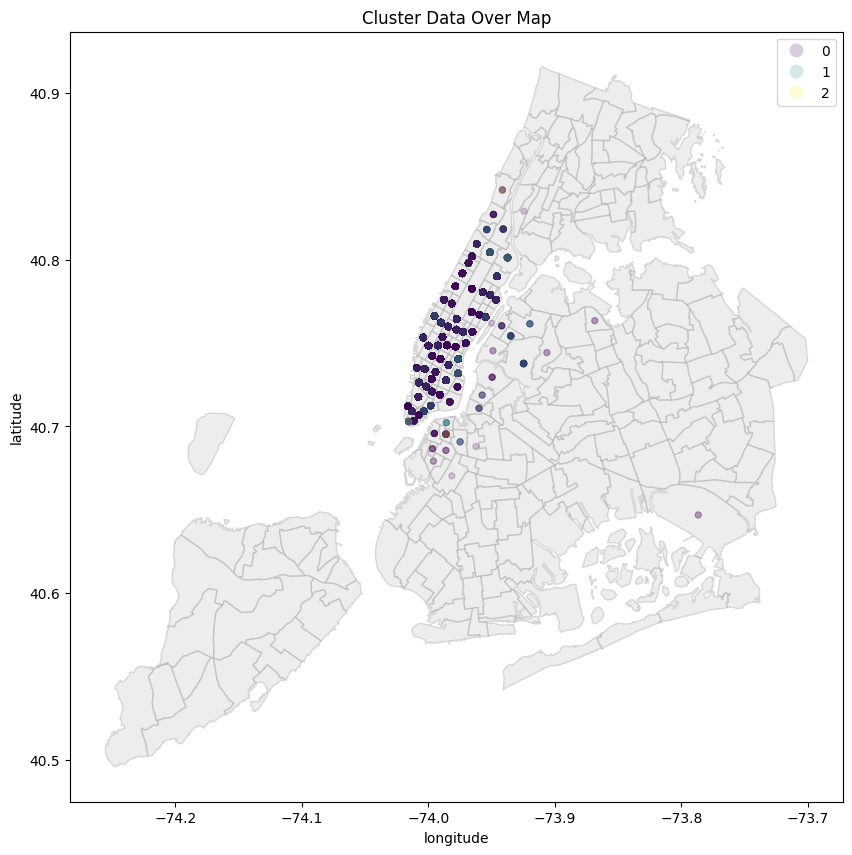

In [ ]:
#Visualize clusters on map

crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(newlatlon_df['longitude'], newlatlon_df['latitude'])]
geo_df = gpd.GeoDataFrame(newlatlon_df,
                          crs = crs,
                          geometry = geometry)
# Set figure size
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')

# Import NYC Neighborhood Shape Files
nyc_full = gpd.read_file('/content/taxi_zones (2).zip')
#nyc_full.crs = 'epsg:2263'
geo_df=geo_df[geo_df['Class'] != -1] #outliers ae removed
nyc_full.to_crs(epsg=4326).plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

geo_df.plot(ax=ax, column='Class', categorical=True, legend=True, alpha=0.2, cmap='viridis', markersize=20, linewidth=0.8, zorder=2)


plt.title('Cluster Data Over Map')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()


fig.clf()




* I have removed the outliers to create a clean visualisation





### Insights from the observed clusters



*  Number of points in the cluster formed
1. Cluster 0: 81338 data points
2. Cluster 1: 46960 data points
3. Cluster 2: 5570 data points

*   All the cluster formed lie between location id 150 to 240 (approx.)
*   Feature comparsion:
1. Passenger count is 1 for almost all cluster
2. Trip distance is between units 1 to 2 accross clusters
3. fare amount for cluster 0> cluster1> cluster2
4. total amount for cluster 0> cluster1> cluster2



### Time based analysis of clusters



In [ ]:
#target_date = '2023-01-16'

#trip_jan_day = trip_jan[trip_jan['tpep_pickup_datetime'].dt.date == pd.to_datetime(target_date).date()]
trip_jan['pickup_hour'] = trip_jan['tpep_pickup_datetime'].dt.hour
trip_jan['dropoff_hour'] = trip_jan['tpep_dropoff_datetime'].dt.hour






In [ ]:
trip_jan.describe()

VendorID  passenger_count  trip_distance  RatecodeID  PULocationID  \
count 134345.00        134345.00      134345.00   134345.00     134345.00   
mean       1.72             1.33           1.73        1.00        173.19   
std        0.45             0.88           1.02        0.10         63.44   
min        1.00             0.00           0.00        1.00          4.00   
25%        1.00             1.00           1.00        1.00        140.00   
50%        2.00             1.00           1.50        1.00        164.00   
75%        2.00             1.00           2.25        1.00        236.00   
max        2.00             6.00           7.00        5.00        264.00   

       DOLocationID  payment_type  fare_amount     extra   mta_tax  \
count     134345.00     134345.00    134345.00 134345.00 134345.00   
mean         171.59          1.19        11.83      1.30      0.50   
std           66.64          0.44         4.81      1.43      0.01   
min            4.00          1.00         0.00      0.00      0.00   
25%          140.00          1.00         7.90      0.00      0.50   
50%          164.00          1.00        10.70      1.00      0.50   
75%          236.00          1.00        14.90      2.50      0.50   
max          264.00          4.00        27.50      5.00      0.80   

       tip_amount  improvement_surcharge  total_amount  congestion_surcharge  \
count   134345.00              134345.00     134345.00             134345.00   
mean         2.42                   1.00         18.85                  2.50   
std          1.63                   0.03          5.70                  0.00   
min          0.00                   0.30          3.50                  2.50   
25%          1.00                   1.00         14.56                  2.50   
50%          2.54                   1.00         18.00                  2.50   
75%          3.50                   1.00         22.33                  2.50   
max          7.45                   1.00         35.10                  2.50   

       airport_fee  pickup_hour  dropoff_hour  
count    134345.00    134345.00     134345.00  
mean          0.00        14.25         14.40  
std           0.00         5.10          5.12  
min           0.00         0.00          0.00  
25%           0.00        11.00         11.00  
50%           0.00        15.00         15.00  
75%           0.00        18.00         18.00  
max           0.00        23.00         23.00

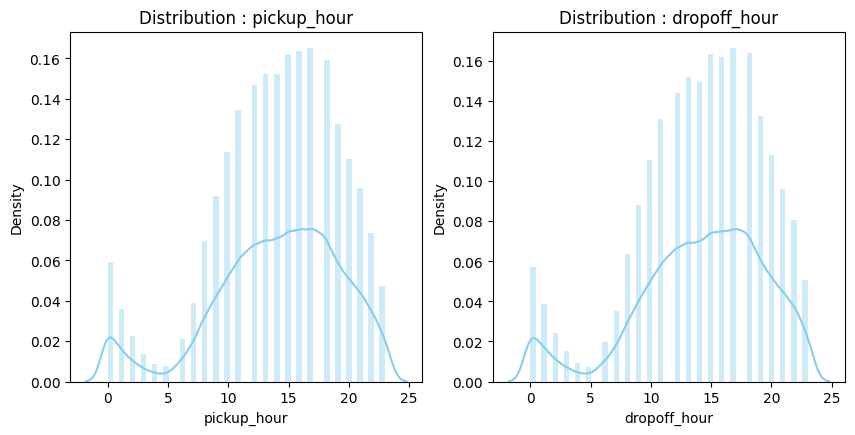

In [ ]:
colors = ['#87CEEB', '#FFA07A']
fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize = (10,10))
arr=['pickup_hour',	'dropoff_hour']
for i in range(len(arr)):
    plt.subplot(2,2,i+1)
    sns.distplot(trip_jan_day[arr[i]],color = colors[0])
    title = 'Distribution : ' + arr[i]
    plt.title(title)
plt.show()



*   Both pickup and drop off have similar frequency distribution,so we will analyse only on pickup hour
*   The number of pickups/dropoffs is higher between 10am to 8pm




### Cluster Based Analysis

In [ ]:
trip_jan.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'airport_fee', 'pickup_hour', 'dropoff_hour'],
      dtype='object')

In [ ]:
trip_jan_day=trip_jan[['PULocationID','pickup_hour']]

#hr_df = pd.merge(trip_copy, trip_jan_day[['PULocationID','pickup_hour']], on='PULocationID', how='left')


In [ ]:
trip_jan_day['Class']=labels

Text(0.5, 1.0, 'Hour vs Class')

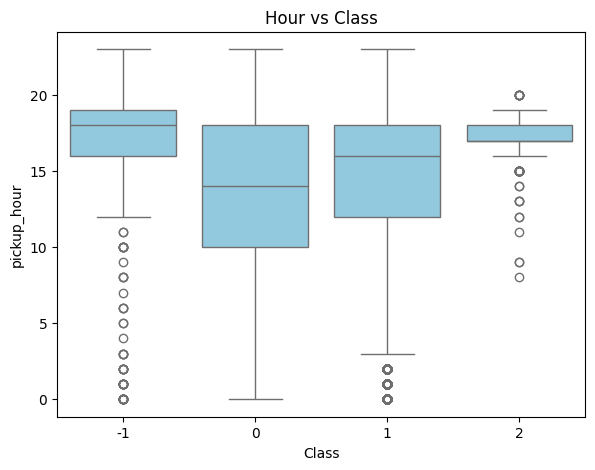

In [ ]:
fig, ax = plt.subplots(nrows = 1, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'pickup_hour', data  = trip_jan_day, color = '#87CEEB');
plt.title('Hour vs Class')

This gives the hours vs cluster distribution

*   For cluster 0,most of the pickup rides are between 10am to 5pm (Range of ride between 0 to 23)
*   For cluster 1,most of the pickup rides are between 2pm to 5pm (Range of ride between 3am to 23)
*   For cluster 2,most of the pickup rides are between 4pm to 5pm (Range of ride between 3pm to 6pm)



## Q2. K-means and Agglomerative clustering for the given dataset

In [ ]:
# Importing Libraries

import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

import plotly.express as px





In [ ]:
!pip install -U kaleido
import kaleido

In [ ]:
df = pd.read_csv("/content/RTYB201920_A3_3c_0.csv")


In [ ]:
df.head()

States/Union Territories  Multiaxled/Articulated Vehicles (I)  \
0           Andhra Pradesh                             10332.00   
1        Arunachal Pradesh                              1544.00   
2                    Assam                              9225.00   
3                    Bihar                             14915.00   
4             Chhattisgarh                             38099.00   

   Trucks and Lorries (II)  Light Motor Vehicles (Goods) (II) - Four Wheelers  \
0                211090.00                                          186730.00   
1                  6367.00                                            7292.00   
2                147374.00                                          157201.00   
3                126414.00                                           87632.00   
4                120980.00                                           98473.00   

   Light Motor Vehicles (Goods) (II) - Three Wheelers  \
0                                           99650.00    
1                                            2566.00    
2                                           50119.00    
3                                           43021.00    
4                                           20573.00    

   Buses (IV) - Stage carriages  Buses (IV) - Contract carriages  \
0                      20890.00                          7246.00   
1                        681.00                          6677.00   
2                       2105.00                         17029.00   
3                      43875.00                             0.00   
4                       7321.00                          1460.00   

   Buses (IV) - Private service vehicles  Buses (IV) - Other buses  \
0                                2343.00                  28820.00   
1                                1189.00                    733.00   
2                                   0.00                   4472.00   
3                                   0.00                      0.00   
4                                7640.00                   3306.00   

   Taxis (V) - Motor cabs  Taxis (V) - Maxi cabs  Taxis (V) - Other taxis  \
0                53568.00               26493.00                 19797.00   
1                   85.00                1015.00                    65.00   
2                21097.00                9647.00                 47933.00   
3               112726.00                   0.00                     0.00   
4                20963.00                 877.00                     0.00   

   Light Motor Vehicles (Passengers) (VI) - Three seaters  \
0                                               0.00        
1                                            7010.00        
2                                          137189.00        
3                                          399096.00        
4                                           46768.00        

   Light Motor Vehicles (Passengers) (VI) - Four to six seaters  \
0                                          619962.00              
1                                            4272.00              
2                                               0.00              
3                                               0.00              
4                                            6072.00              

   Motor cycles on hire (VII)  Other vehicles not included in (I-VII)  \
0                      703.00                               340010.00   
1                        0.00                                    0.00   
2                        0.00                                    0.00   
3                        0.00                                    0.00   
4                        0.00                                    0.00   

   Total Transport (I TO VII)  
0                  1627634.00  
1                    39496.00  
2                   603391.00  
3                   827679.00  
4                   372532.00

In [ ]:
df.describe()

Multiaxled/Articulated Vehicles (I)  Trucks and Lorries (II)  \
count                                36.00                    36.00   
mean                              90699.67                323692.83   
std                              301335.17                961466.66   
min                                   0.00                     0.00   
25%                                   1.50                 10684.75   
50%                                1510.50                123697.00   
75%                               43748.50                261662.00   
max                             1632594.00               5826471.00   

       Light Motor Vehicles (Goods) (II) - Four Wheelers  \
count                                              36.00   
mean                                           260964.00   
std                                            782684.08   
min                                                 0.00   
25%                                              9692.00   
50%                                             52491.00   
75%                                            192204.50   
max                                           4697352.00   

       Light Motor Vehicles (Goods) (II) - Three Wheelers  \
count                                              36.00    
mean                                           118435.78    
std                                            361328.82    
min                                                 0.00    
25%                                                55.50    
50%                                              6611.50    
75%                                             94671.50    
max                                           2131844.00    

       Buses (IV) - Stage carriages  Buses (IV) - Contract carriages  \
count                         36.00                            35.00   
mean                       54647.89                         19377.83   
std                       166253.19                         58680.31   
min                            0.00                             0.00   
25%                         2132.75                             0.00   
50%                        15771.00                          1323.00   
75%                        35180.00                         12781.50   
max                       983662.00                        339112.00   

       Buses (IV) - Private service vehicles  Buses (IV) - Other buses  \
count                                  35.00                     35.00   
mean                                 7643.09                  15251.14   
std                                 23419.46                  47266.57   
min                                     0.00                      0.00   
25%                                     0.00                      0.00   
50%                                   144.00                     47.00   
75%                                  4346.00                   5878.00   
max                                133754.00                 266895.00   

       Taxis (V) - Motor cabs  Taxis (V) - Maxi cabs  Taxis (V) - Other taxis  \
count                   36.00                  35.00                    35.00   
mean                131333.17               53535.60                  9031.26   
std                 390746.50              164036.36                 28141.21   
min                     85.00                   0.00                     0.00   
25%                   8668.75                 348.50                     0.00   
50%                  43200.00                3619.00                    28.00   
75%                 108250.00               32386.00                  2880.00   
max                2363997.00              936873.00                158047.00   

       Light Motor Vehicles (Passengers) (VI) - Three seaters  \
count                                              36.00        
mean                                           333766.50        
std                                

In [ ]:
df = df.drop(32)

In [ ]:
df=df.drop(36)

In [ ]:
df = df.drop(columns=['Total Transport (I TO VII)'])

In [ ]:
df_copy1=df.copy()
col = list(df_copy1.columns)
col.remove('States/Union Territories')
numerical_features = [*col]

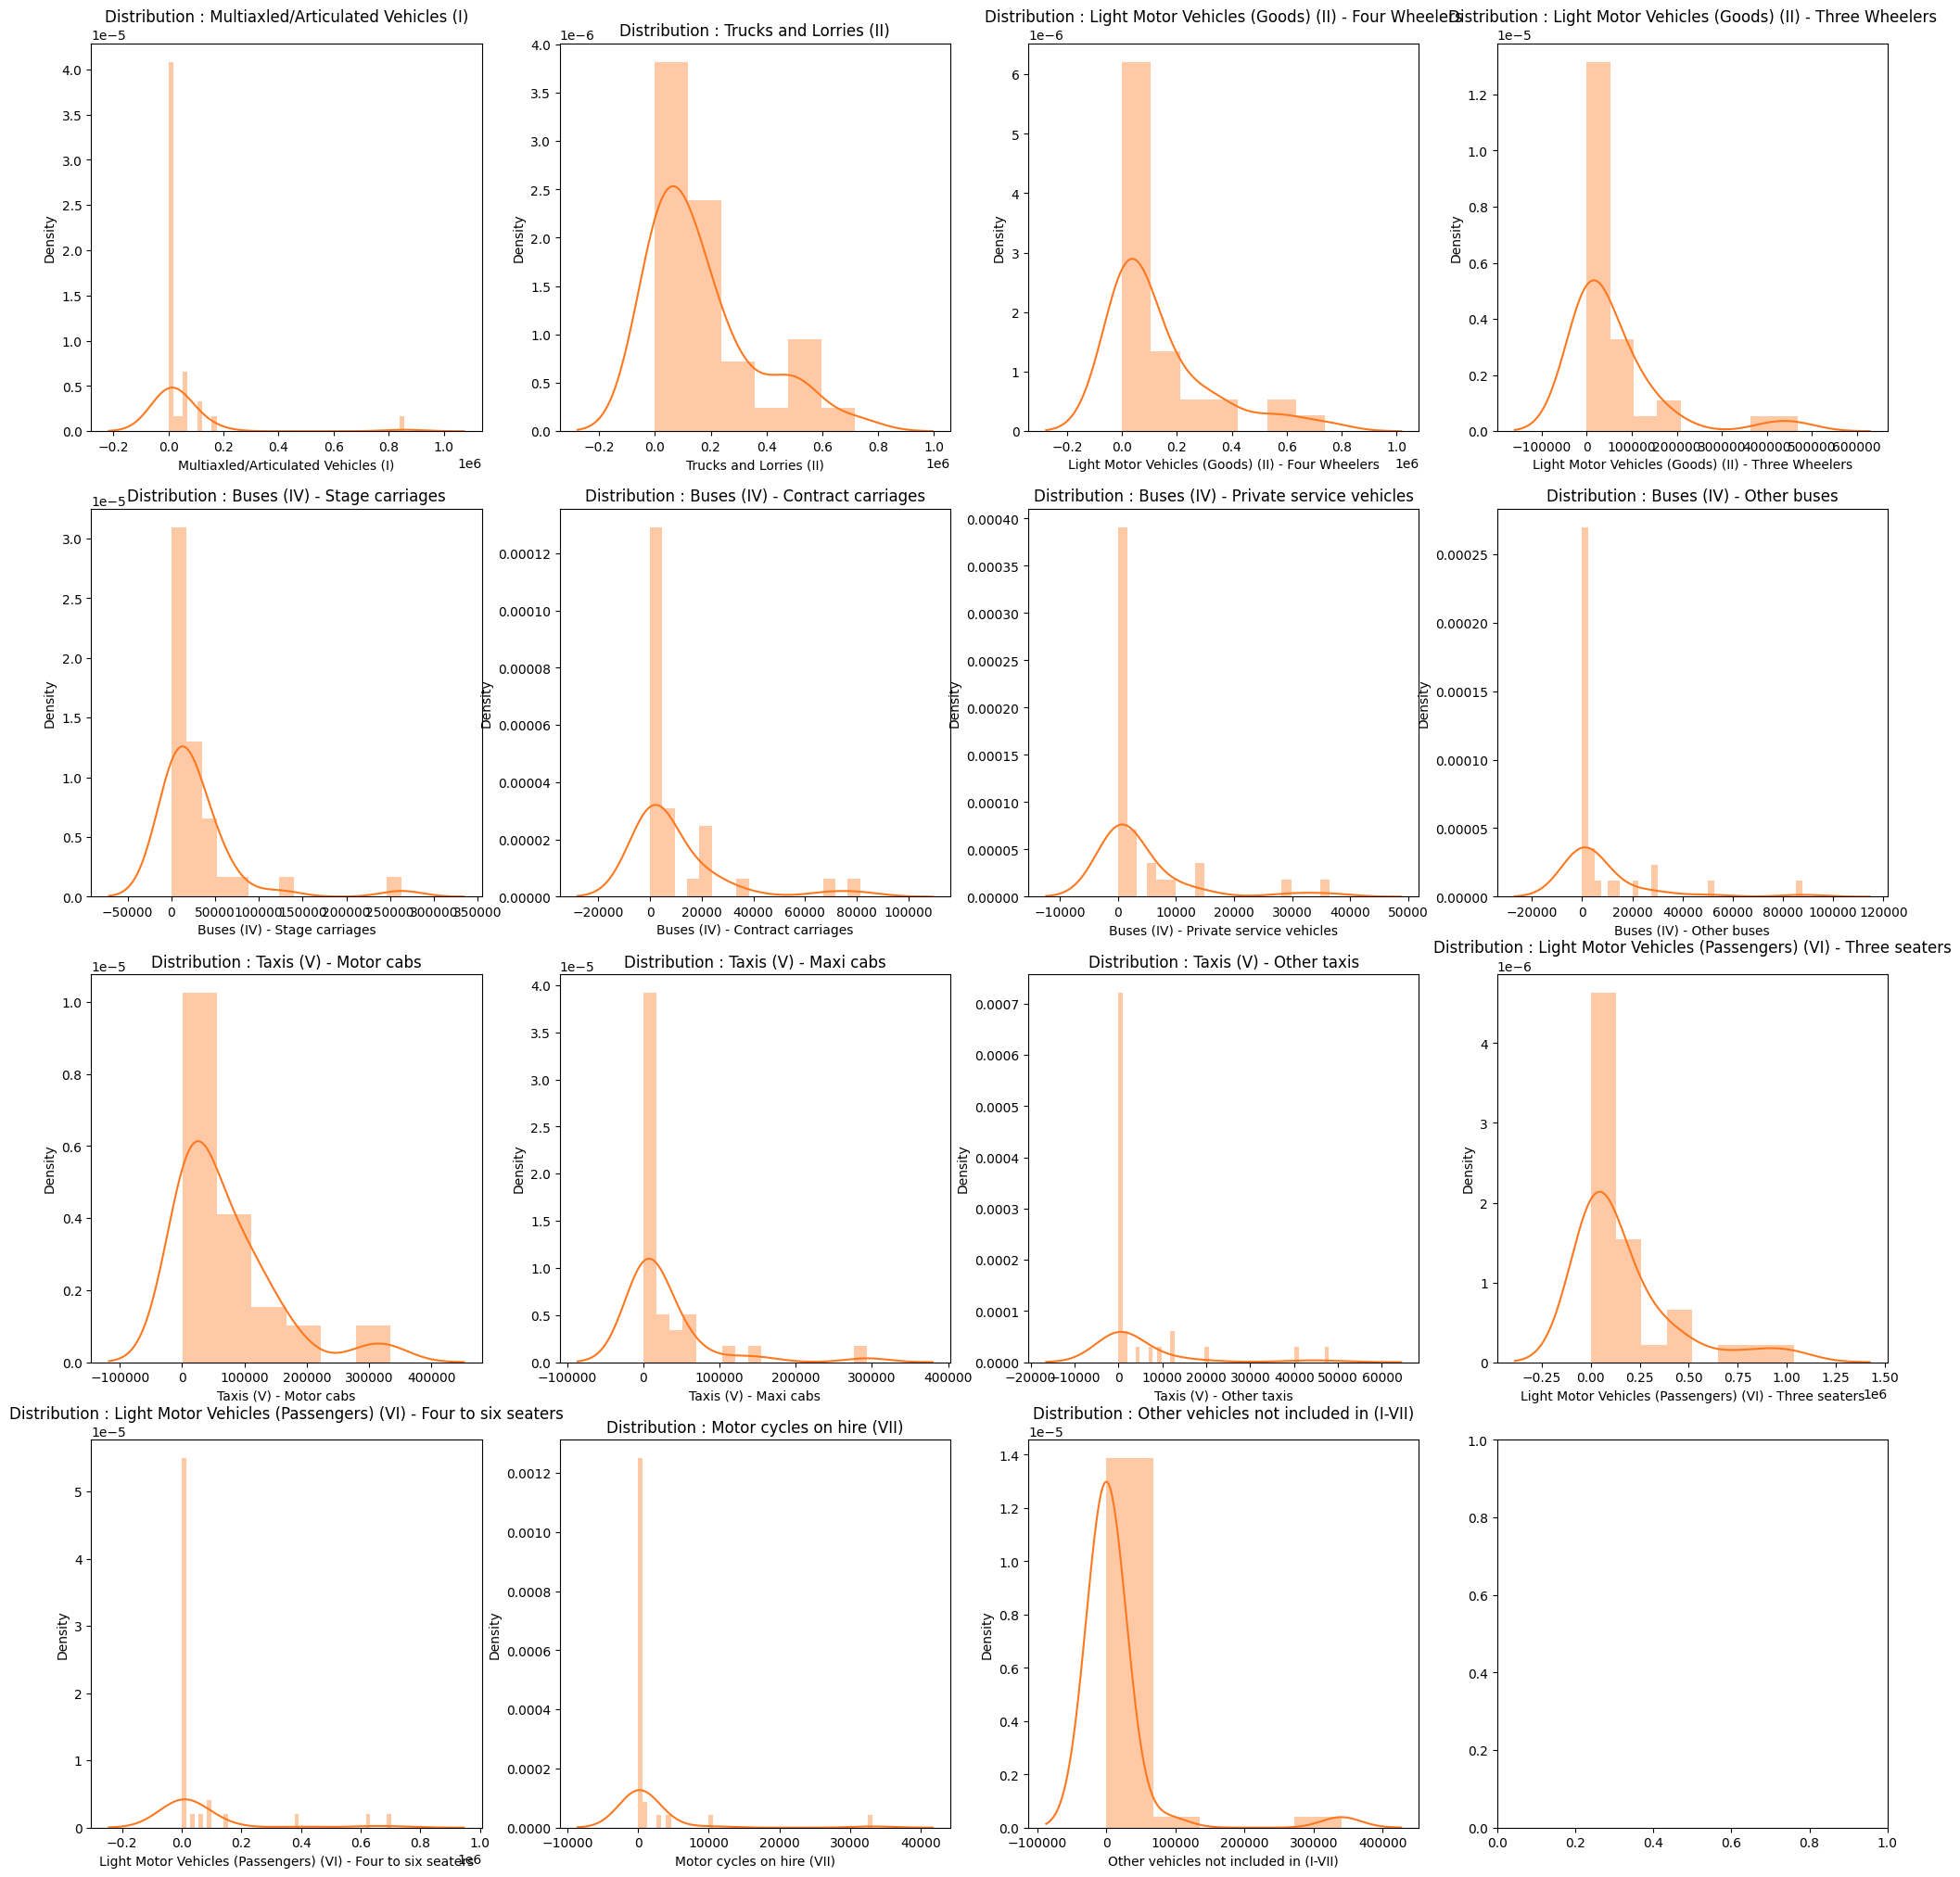

In [ ]:
#Visualize the dataset
colors = ['#FF781F','#2D2926']

fig, ax = plt.subplots(nrows = 4,ncols = 4,figsize = (25,25))
for i in range(len(numerical_features)):
    plt.subplot(4,4,i+1)
    sns.distplot(df_copy1[numerical_features[i]],color = colors[0])
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

In [ ]:
df_copy1.fillna(0, inplace=True)

Almost all the features are correlated

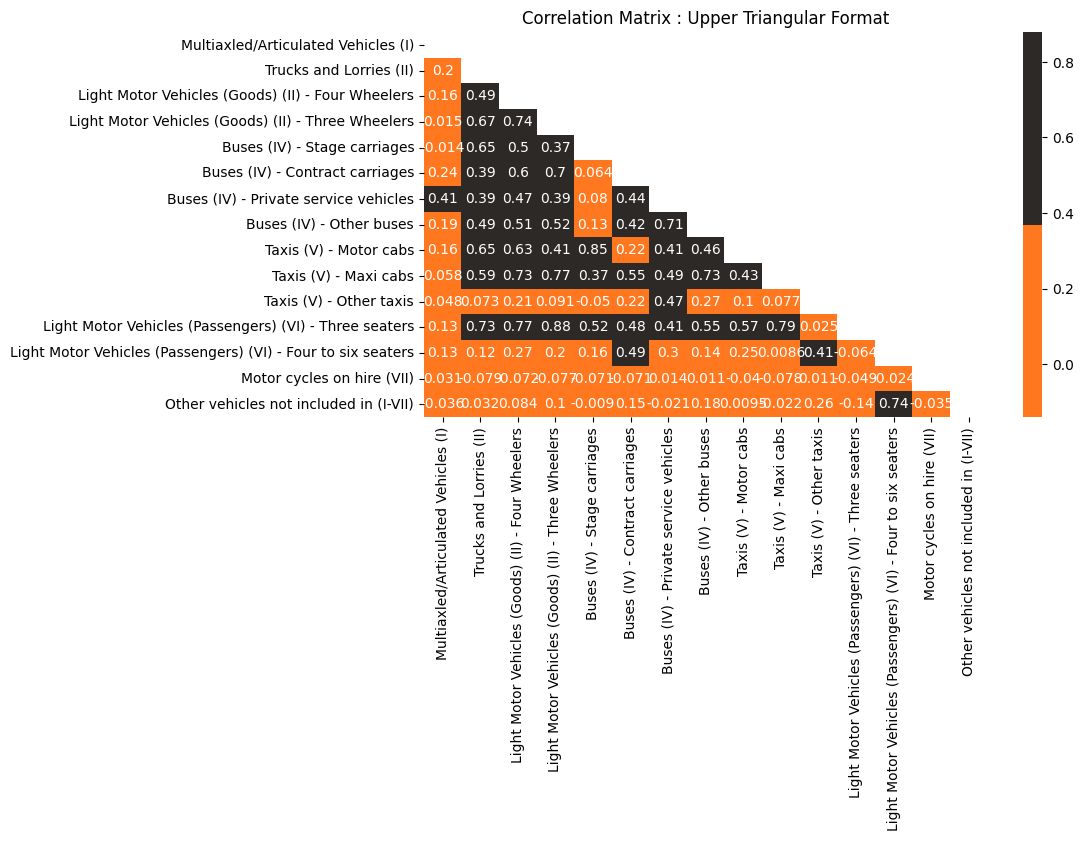

In [ ]:
# Correlation matrix

ut = np.triu(df_copy1.corr())


fig,ax = plt.subplots(nrows = 1,figsize = (20,5))
plt.subplot(1,2,1)
sns.heatmap(df_copy1.corr(),cmap = colors,annot = True,cbar = 'True',mask = ut);
plt.title('Correlation Matrix : Upper Triangular Format');

### PCA

In [ ]:
# Feature scaling

from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization


In [ ]:
#We will MMS as the data is not normally distributed but highly skewed
df_copy1.drop(columns = 'States/Union Territories',inplace = True)
col1 = list(df_copy1.columns)
for i in col1:
    df_copy1[i] = mms.fit_transform(df_copy1[[i]]) # Normalization

df_copy1.head()

Multiaxled/Articulated Vehicles (I)  Trucks and Lorries (II)  \
0                                 0.01                     0.29   
1                                 0.00                     0.01   
2                                 0.01                     0.21   
3                                 0.02                     0.18   
4                                 0.04                     0.17   

   Light Motor Vehicles (Goods) (II) - Four Wheelers  \
0                                               0.25   
1                                               0.01   
2                                               0.21   
3                                               0.12   
4                                               0.13   

   Light Motor Vehicles (Goods) (II) - Three Wheelers  \
0                                               0.21    
1                                               0.01    
2                                               0.11    
3                                               0.09    
4                                               0.04    

   Buses (IV) - Stage carriages  Buses (IV) - Contract carriages  \
0                          0.08                             0.09   
1                          0.00                             0.08   
2                          0.01                             0.21   
3                          0.17                             0.00   
4                          0.03                             0.02   

   Buses (IV) - Private service vehicles  Buses (IV) - Other buses  \
0                                   0.06                      0.33   
1                                   0.03                      0.01   
2                                   0.00                      0.05   
3                                   0.00                      0.00   
4                                   0.21                      0.04   

   Taxis (V) - Motor cabs  Taxis (V) - Maxi cabs  Taxis (V) - Other taxis  \
0                    0.16                   0.09                     0.41   
1                    0.00                   0.00                     0.00   
2                    0.06                   0.03                     1.00   
3                    0.34                   0.00                     0.00   
4                    0.06                   0.00                     0.00   

   Light Motor Vehicles (Passengers) (VI) - Three seaters  \
0                                               0.00        
1                                               0.01        
2                                               0.13        
3                                               0.39        
4                                               0.05        

   Light Motor Vehicles (Passengers) (VI) - Four to six seaters  \
0                                               0.88              
1                                               0.01              
2                                               0.00              
3                                               0.00              
4                                               0.01              

   Motor cycles on hire (VII)  Other vehicles not included in (I-VII)  
0                        0.02                                    1.00  
1                        0.00                                    0.00  
2                        0.00                                    0.00  
3                        0.00                                    0.00  
4                        0.00                                    0.00

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca_df = pd.DataFrame(pca.fit_transform(df_copy1))
pca.explained_variance_

array([0.32370005, 0.10545057, 0.06718396, 0.05699102, 0.03630087,
       0.03201507, 0.0303573 , 0.02760381, 0.01699609, 0.01066789,
       0.00779574, 0.00545373, 0.00184295, 0.00073515, 0.00053652])

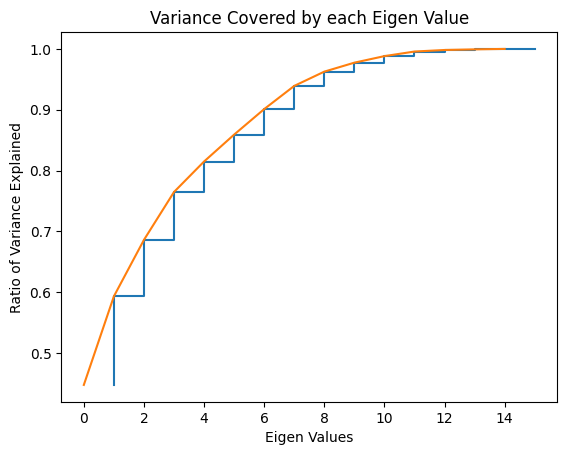

In [ ]:
plt.step(list(range(1, len(pca.explained_variance_ratio_) + 1)), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Eigen Values')
plt.ylabel('Ratio of Variance Explained')
plt.title('Variance Covered by each Eigen Value')
plt.show()

In [ ]:
pca_df = pca_df.drop(columns = [9,10,11,12,13,14])
pca_df.head()

0     1     2     3     4     5     6     7     8
0  0.19  0.98  0.44 -0.32 -0.12 -0.38  0.24 -0.35  0.35
1 -0.43 -0.00 -0.12 -0.06  0.01  0.01 -0.05 -0.05 -0.05
2 -0.03  0.41 -0.17  0.19 -0.54 -0.08 -0.18  0.47  0.16
3 -0.05 -0.24  0.13 -0.00 -0.05  0.05 -0.04  0.01  0.04
4 -0.24 -0.02 -0.09  0.07  0.05 -0.01 -0.06 -0.05 -0.02

In [ ]:
m=pca_df.values

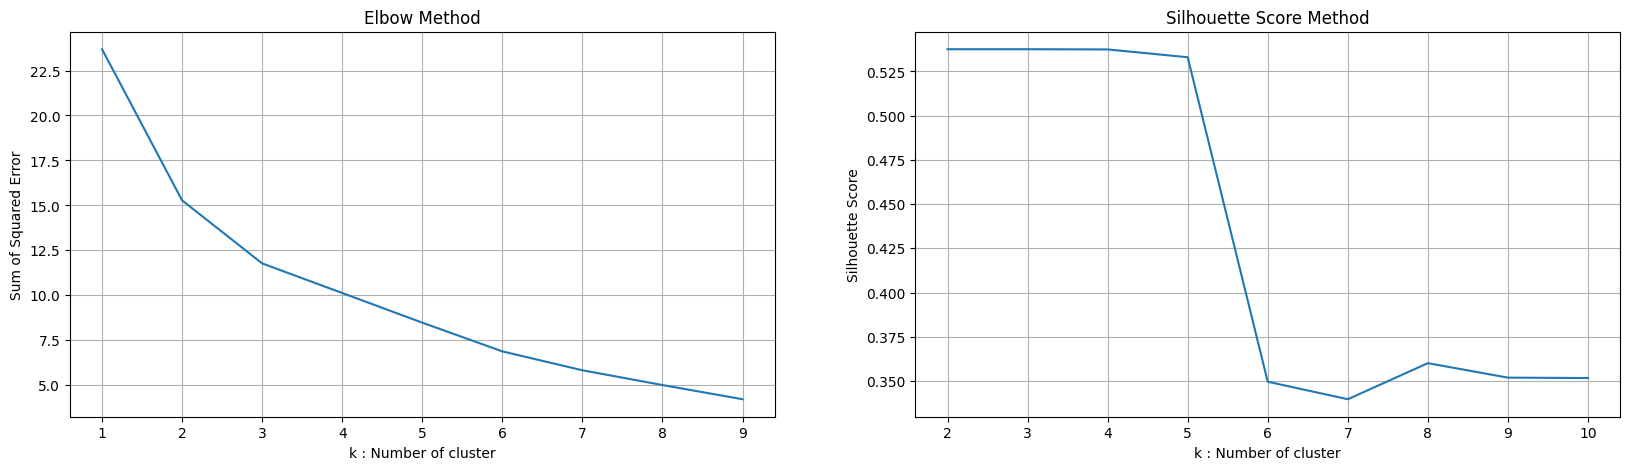

In [ ]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(m)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(m)
    labels = kmeans.labels_
    sil.append(silhouette_score(m, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()


**Number of cluster: 3**


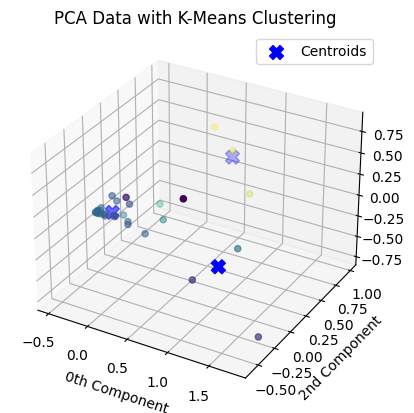

In [ ]:
model = KMeans(n_clusters=3)
model.fit(m)
cluster = model.cluster_centers_
centroids = np.array(cluster)
labels = model.labels_
df_copy1['Class'] = labels; pca_df['Class'] = labels

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extracting principal components
x = pca_df[0]
y = pca_df[1]
z = pca_df[2]


# Plotting data points
ax.scatter(x, y,z, c=y, cmap='viridis')

# Plotting centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker="X", color='b', s=100, label='Centroids')

plt.title('PCA Data with K-Means Clustering')
ax.set_xlabel('0th Component')
ax.set_ylabel('1st Component')
ax.set_ylabel('2nd Component')

plt.legend()
plt.show()

In [ ]:
df['cluster'] = labels

In [ ]:
labels

array([2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

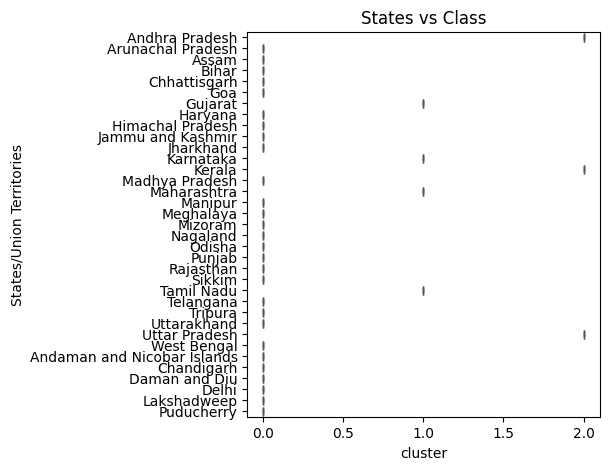

In [ ]:
fig, ax = plt.subplots(nrows = 1, figsize = (10,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'cluster', y = 'States/Union Territories', data  = df, color = '#FF781F');
plt.title('States vs Class')

plt.show()

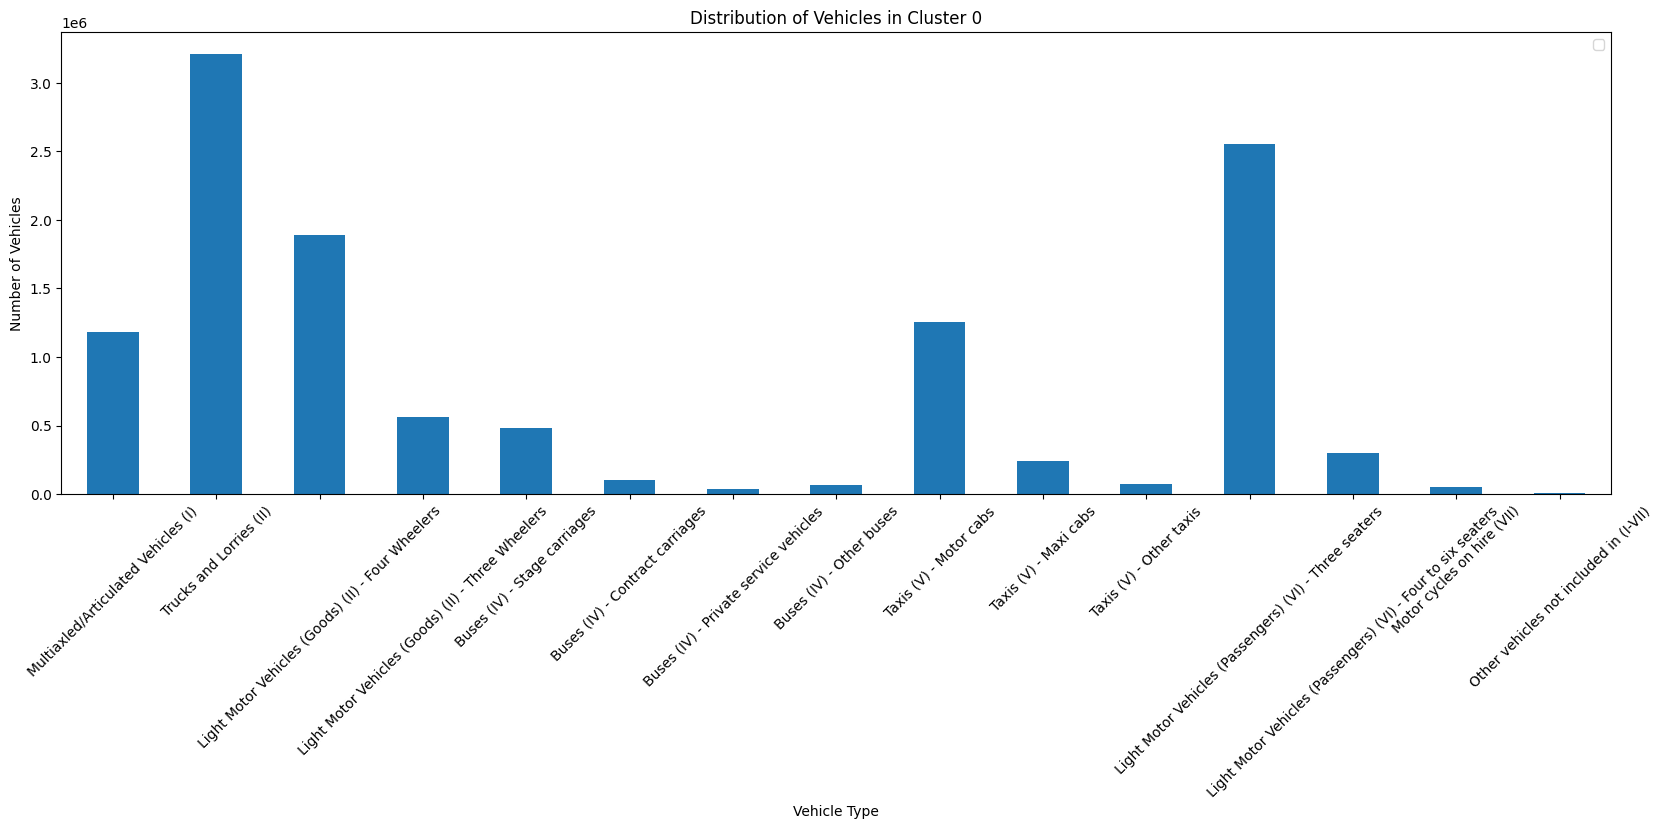

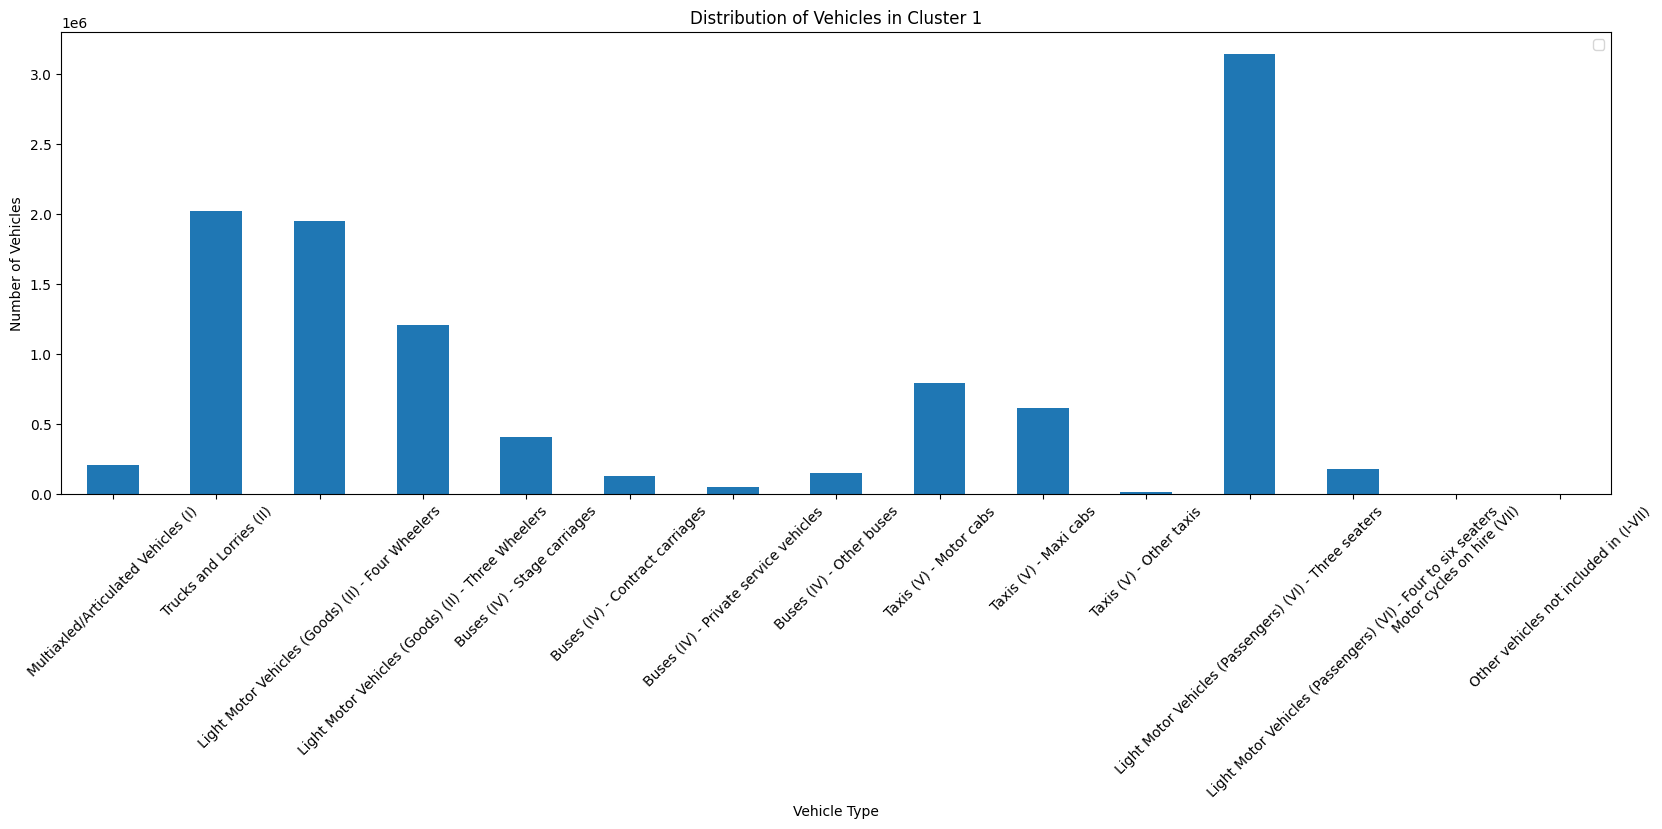

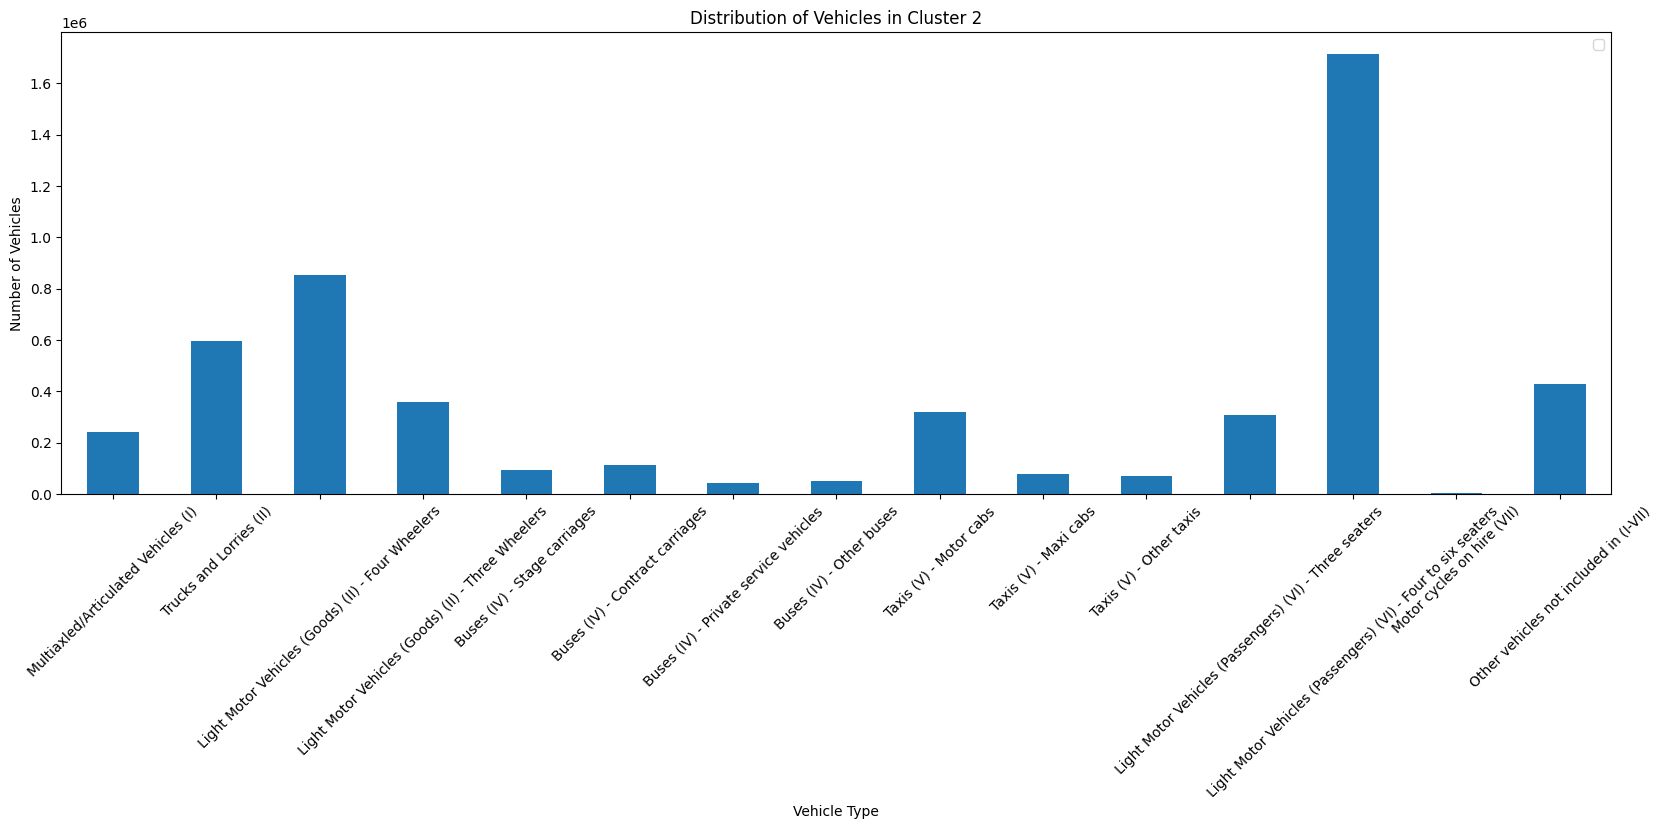

In [ ]:
for cluster_lab in range(3):
    # Filter the dataset for the current cluster
    cluster_data = cluster_dis[cluster_dis['cluster_label'] == cluster_lab]

    # Plot the frequency distribution for vehicles in the current cluster
    cluster_data.drop('cluster_label', axis=1).sum().plot(kind='bar', figsize=(20, 6))

    # Set plot labels and title
    plt.xlabel('Vehicle Type')
    plt.ylabel('Number of Vehicles')
    plt.title(f'Distribution of Vehicles in Cluster {cluster_lab}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

### Insights

*   There are three clusters formed 0,1 and 2
*   Cluster 0 corresponds to maximum number of states
*   Cluster 1 corresponds to 4 states
*   Cluster 2 corresponds to 3 other states

### Marketing Campaign
(Based on high frequency registration)
*   For cluster 0 and the states that include those clusters we can target trucks and lorries,light motor vehicles 4 wheeler and taxies.
*   For cluster 1 we can target multiaxled/Articulated vehicles and Taxis-other taxis
*   For cluster 2,we can target light motor vehicles(passengers)four to six seater motor cycles on hire



### Agglomerative Clustering

Using this type of clustering has resulted similar cluster and distribution

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

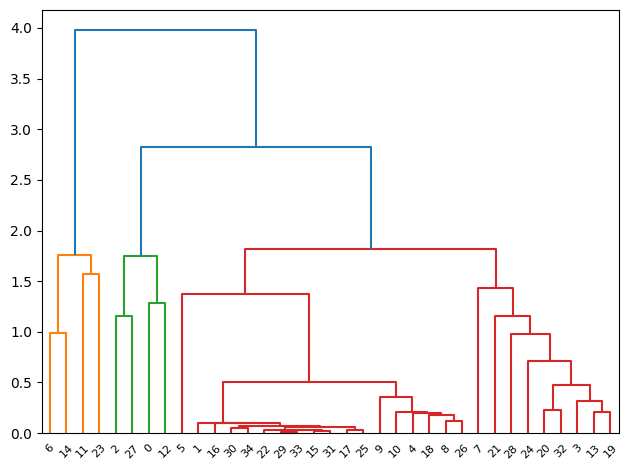

In [ ]:
linkage_data = linkage(m, method = 'ward', metric = 'euclidean')
dendrogram(linkage_data)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
labels = hierarchical_cluster.fit(m)

pred_agc = pd.Series(hierarchical_cluster.labels_)
df['Class'] = pred_agc; pca_df['Class'] = pred_agc

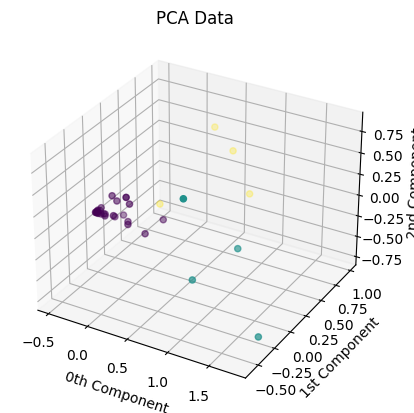

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(pca_df[0])
y = np.array(pca_df[1])
z = np.array(pca_df[2])
ax.scatter(x,y,z,c = pca_df['Class'])
plt.title('PCA Data')
ax.set_xlabel('0th Component')
ax.set_ylabel('1st Component')
ax.set_zlabel('2nd Component')
plt.show();

Text(0.5, 1.0, 'child_mort vs Class')

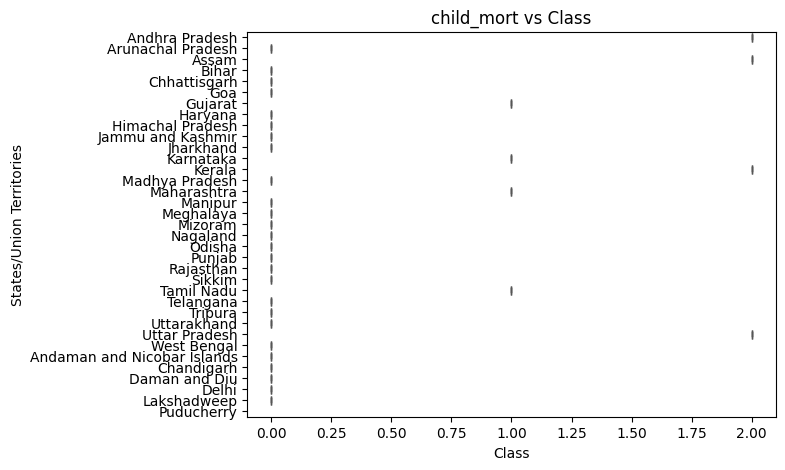

In [ ]:
fig, ax = plt.subplots(nrows = 1, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'Class', y = 'States/Union Territories', data  = df, color = '#FF781F');
plt.title('child_mort vs Class')


## Q3:  Association rule mining on Spotify dataset

In [ ]:
import pandas as pd  # Import Pandas library for data manipulation
import numpy as np  # Import NumPy library for numerical operations
import seaborn as sns  # Import Seaborn library for visualization
import matplotlib.pyplot as plt  # Import Matplotlib library for plotting
import matplotlib.style  # Import Matplotlib style module

from mlxtend.frequent_patterns import apriori, association_rules  # Import Apriori algorithm for association rule mining

from collections import Counter  # Import Counter from collections module for counting occurrences
from mlxtend.preprocessing import TransactionEncoder
from tabulate import tabulate


from warnings import filterwarnings  # Import filterwarnings function from warnings module to suppress warnings
filterwarnings("ignore", category=DeprecationWarning)  # Suppress DeprecationWarning

In [ ]:
import plotly.graph_objects as go
import plotly.express as px


In [ ]:
!pip install apyori
from apyori import apriori

  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5954 sha256=c7a29dcc893ecac928e9098c7af403a17f248e4b0710b9b811af5aa922f9a6bd
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori


In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
spotify_df=pd.read_csv('/kaggle/input/spotify-playlist/spotify_dataset.csv',on_bad_lines='skip')

In [ ]:
spotify_df.head()

user_id                      "artistname"  \
0  9cc0cfd4d7d7885102480dd99e7a90d6                    Elvis Costello   
1  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello & The Attractions   
2  9cc0cfd4d7d7885102480dd99e7a90d6                      Tiffany Page   
3  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello & The Attractions   
4  9cc0cfd4d7d7885102480dd99e7a90d6                    Elvis Costello   

                                         "trackname"  "playlistname"  
0               (The Angels Wanna Wear My) Red Shoes  HARD ROCK 2010  
1  (What's So Funny 'Bout) Peace, Love And Unders...  HARD ROCK 2010  
2                                   7 Years Too Late  HARD ROCK 2010  
3                              Accidents Will Happen  HARD ROCK 2010  
4                                             Alison  HARD ROCK 2010

In [ ]:
spotify_df.shape

(40000, 4)

In [ ]:
spotify_df.head()

user_id                      "artistname"  \
0  9cc0cfd4d7d7885102480dd99e7a90d6                    Elvis Costello   
1  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello & The Attractions   
2  9cc0cfd4d7d7885102480dd99e7a90d6                      Tiffany Page   
3  9cc0cfd4d7d7885102480dd99e7a90d6  Elvis Costello & The Attractions   
4  9cc0cfd4d7d7885102480dd99e7a90d6                    Elvis Costello   

                                         "trackname"  "playlistname"  
0               (The Angels Wanna Wear My) Red Shoes  HARD ROCK 2010  
1  (What's So Funny 'Bout) Peace, Love And Unders...  HARD ROCK 2010  
2                                   7 Years Too Late  HARD ROCK 2010  
3                              Accidents Will Happen  HARD ROCK 2010  
4                                             Alison  HARD ROCK 2010

In [ ]:
#Null values

for column in spotify_df.columns:
    null_count = spotify_df[column].isnull().sum()
    print(f"Number of null values in '{column}': {null_count}")

Number of null values in 'user_id': 0
Number of null values in '"artistname"': 21
Number of null values in '"trackname"': 0
Number of null values in '"playlistname"': 3


In [ ]:
#drop null values

for column in spotify_df.columns:
    spotify_df = spotify_df.dropna(subset=[column])

In [ ]:
#Number of artist,tracks and playlists
#spotify_df1=spotify_df.copy()
#spotify_df1=spotify_df1.drop('user_id',axis=1, inplace=True)

for column in spotify_df.columns:
    Products = spotify_df[column].unique()
    print(f"Total '{column}': {len(Products)}" )

Total 'user_id': 51
Total '"artistname"': 8061
Total '"trackname"': 27664
Total '"playlistname"': 737


* As track name has too many unique value,we can drop it in analysing user pattern.

In [ ]:
#Frequent artist

def ditribution_plot(x,y,name=None,xaxis=None,yaxis=None):
    fig = go.Figure([
        go.Bar(x=x, y=y,marker=dict(color='blue'))
    ])

    fig.update_layout(
        title_text=name,
        xaxis_title=xaxis,
        yaxis_title=yaxis
    )
    fig.show()

In [ ]:
columns=['"artistname"','"trackname"','"playlistname"']
for column in columns:
    x = spotify_df[column].value_counts()
    x = x.sort_values(ascending = False)
    x = x[:10]

    ditribution_plot(x=x.index, y=x.values, yaxis="Count", xaxis=column)

####  Distribution of Artist,trackname and playlistname

* Top artist: Jay Z, Nas, Nine Inch Nails
* Top Tracks: Home,Pompeii,Intro
* Top playlists: Everything at once,Starred,las canciones de mi vi

**Note**: Some figures are not displayed because the notebook was run on kaggle notebooks and copied to colab

In [ ]:
spotify_df = spotify_df.drop(spotify_df.columns[4:], axis=1)

In [ ]:
spotify_df.columns = [column.strip() for column in spotify_df.columns]


In [ ]:
spotify_df = spotify_df.head(40000)

In [ ]:

spotify_df.isnull().sum().sort_values(ascending=False)

min_support = 0.005

encode_art = pd.get_dummies(spotify_df['"artistname"'])

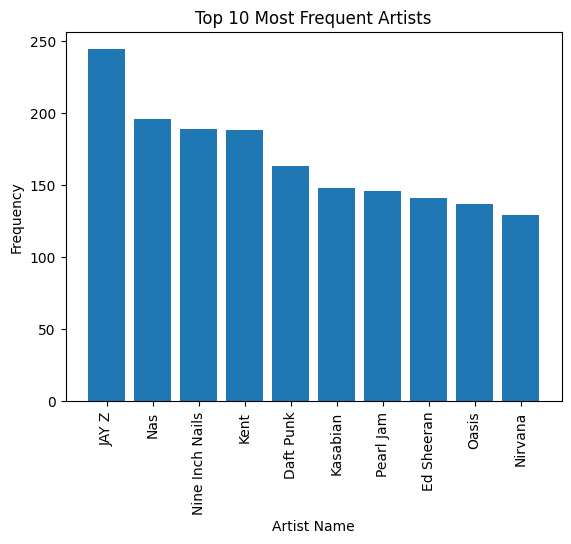

In [ ]:
#generating association rules

art_item = apriori(encode_art, min_support=min_support, use_colnames=True)
artist_rules = association_rules(art_item, metric="confidence", min_threshold=0.02)

min_support = 0.001



top_art = artist_encoded.sum().sort_values(ascending=False).head(10)
plt.bar(top_art.index, top_art.values)
plt.xticks(rotation=90)
plt.xlabel('Artist Name')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Artists')
plt.show()

In [ ]:
#Encoding for playlist

encode_play = pd.get_dummies(spotify_df['"playlistname"'])


item_play = apriori(encode_play, min_support=min_support, use_colnames=True)
playlist_rules = association_rules(item_play, metric="confidence", min_threshold=0.03)

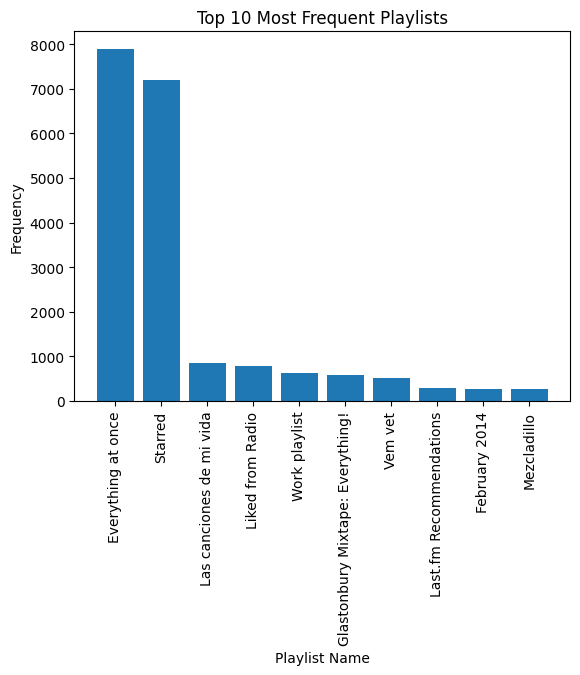

Strongest Association Rules for Artists:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []

Strongest Association Rules for Playlists:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []


In [ ]:

# Visualize playlist
top_play = encode_play.sum().sort_values(ascending=False).head(10)
plt.bar(top_play.index,top_play.values)
plt.xticks(rotation=90)
plt.xlabel('Playlist Name')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Playlists')
plt.show()


sorted_artist = artist_rules.sort_values(by='lift', ascending=False)
sorted_playlist = playlist_rules.sort_values(by='lift', ascending=False)

print("Strongest Association Rules for Artists:")
print(sorted_artist.head())
print("\nStrongest Association Rules for Playlists:")
print(sorted_playlist.head())





* No strong rules found for this size of the dataset

### Recommending list

In [ ]:
#creating a recommending list

top_art = encode_art.sum().sort_values(ascending=False).head(5)  # Top 5 most frequent artists
top_play = encode_play.sum().sort_values(ascending=False).head(5)  # Top 5 most frequent playlists


popular = spotify_df[(spotify_df['"artistname"'].isin(top_art.index)) &
                             (spotify_df['"playlistname"'].isin(top_play.index))]

# Recommendation
recommended = popular.sample(n=10, random_state=42)  # Sample 10 songs randomly


recommended_list = recommended[['"artistname"', '"playlistname"', '"trackname"']].values.tolist()


headers = ['Artist Name', 'Playlist Name', 'Track Name']


print(tabulate(recommended_list, headers=headers, tablefmt='grid'))

+-----------------+--------------------+-----------------------------------------------------------------+
| Artist Name     | Playlist Name      | Track Name                                                      |
+=================+====================+=================================================================+
| Daft Punk       | Starred            | Technologic                                                     |
+-----------------+--------------------+-----------------------------------------------------------------+
| Nas             | Starred            | U Gotta Love It                                                 |
+-----------------+--------------------+-----------------------------------------------------------------+
| Nas             | Starred            | You're Da Man                                                   |
+-----------------+--------------------+-----------------------------------------------------------------+
| JAY Z           | Starred          